# Import packages

In [1]:
from getpass import getuser # Libaray to copy things
from tempfile import NamedTemporaryFile, TemporaryDirectory 

import dask

from dask.distributed import Client
import multiprocessing

ncpu = multiprocessing.cpu_count()
threads = 8
nworker = ncpu // threads
print(
    f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}"
)
client = Client(
    processes=True, threads_per_worker=threads, n_workers=nworker, memory_limit="100GB"
)
client 

# calculation
import .calc as mpcalc

# scipy
from scipy import stats
from scipy.ndimage import measurements
from scipy import ndimage
from scipy.optimize import curve_fit

# for plot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# basic
from pathlib import Path # Object oriented libary to deal with paths
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
import netCDF4 as nc
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data

# dask
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

Number of CPUs: 256, number of threads: 8, number of workers: 32


2024-07-16 15:20:17,151 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project1/dask-worker-space/worker-vqc_ypxs', purging
2024-07-16 15:20:17,160 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project1/dask-worker-space/worker-hkf2ouf6', purging
2024-07-16 15:20:17,204 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project1/dask-worker-space/worker-jaye65ya', purging
2024-07-16 15:20:17,229 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project1/dask-worker-space/worker-r2cfum7k', purging
2024-07-16 15:20:17,261 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project1/dask-worker-space/worker-ixlnl901', purging
2024-07-16 15:20:17,280 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Pro

In [2]:
import sys
sys.path.append('/home/m/m300948/ICON_AMZDEF')
import Tools

Number of CPUs: 256, number of threads: 8, number of workers: 32


# SAL method

**List files of interpolated data**

In [51]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'ctl_daily_pr_202'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/scratch/m/m300948/test_04/pr')

## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_icon_pp = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

In [4]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'def_daily_pr_202'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/scratch/m/m300948/def_100/pr')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_def_pp = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

**List files of IMERG**

In [3]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'IMERG_precipitationrate_V06B_daily_0.1degree_tropics_30S_30N_'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/obs/IMERG')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_imerg = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

_calculate land_sea mask_

In [11]:
def mask_cal(dset):
    ##This function calculate the land_sea mask according to the resolution of the data##
    ###negative values is ocean, positive values is land
    filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
    dsetmask = xr.open_dataset(filemask)
    lsmask01 = dsetmask.landseamask.where(
        dsetmask.landseamask<100).interp(lon=dset.lon.values,lat=dset.lat.values,method='linear') *0 +2
    lsmask01 = lsmask01.where(lsmask01==2,-2)
    return lsmask01

In [12]:
def masking_15060(dset):
    file_mask = '/work/mh0731/m300948/AMDEF/REGRID_BC/amz_100def/scena_100_implement/amz_masking_15040_6040.nc'
    var_names = 'forest_fract'
  
    dset_nc = nc.Dataset(file_mask, mode='r')
    dset_xr = xr.open_dataset(xr.backends.NetCDF4DataStore(dset_nc))
    #dset_mask = dset_xr.sel(lat=slice(-30,30))
    dset_mask = dset_xr[var_names].persist()
    dset_mask = dset_mask.fillna(100)

    dset['lat'] = dset_mask['lat']
    dset['lon'] = dset_mask['lon']

    dset_replace = dset.where(dset_mask == 0, np.nan)
    return dset_replace

_calculate time mean data_

In [52]:
# 1MS, 1H, 1D, 1Y
def time_mean_model(file,times,var,lat,lon,environ):
    ##Funtion to calculate the monthly mean of precipitation from the model
    ###the environ option mask the values over land or ocean:
        ## if environ = 'trop' -> no mask is used
        ## if environ = 'ocean' -> return only values over ocean
        ## if environ = 'land' -> return only values over land
    dset = xr.open_mfdataset(file, engine='netcdf4', combine='by_coords',chunks=({'time':20})).sel(
        time=slice(times[0],times[1]))
    if environ == 'trop':
        pr=dset[var].sel(
            time=slice(times[0],times[1])).sel(
            lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1])).resample(time='1MS').mean(dim=('time'),skipna=True) 
    else:
        lsmask01 = mask_cal(dset)
        if environ == 'ocean':
            pr=dset[var].where(lsmask01<0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1])).resample(
                time='1MS').mean(dim=('time'),skipna=True)
        elif environ == 'land':
            pr=dset[var].where(lsmask01>0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1])).resample(
                time='1MS').mean(dim=('time'),skipna=True)
        else:
            return print('no correct environment')
    jobs = dask.persist(pr)
    varf = dask.compute(pr)[0]
    #pr_mon = varf.groupby('time.month').mean()
    pr_mon = varf
    return pr_mon*3600*24
    #return pr_mon*3600*24

In [4]:
def time_mean_imerg_multi(file,lat,lon,environ):
    ##Funtion to calculate the climatology monthly mean of precipitation from IMERG
    ###the environ option mask the values over land or ocean:
        ## if environ = 'trop' -> no mask is used
        ## if environ = 'ocean' -> return only values over ocean
        ## if environ = 'land' -> return only values over land
    data = xr.open_mfdataset(
        file, combine='by_coords',engine='netcdf4',chunks=({'time':20}))['calibrated_precipitation']
    if environ == 'trop':
        pr=data.sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1]))
    else:
        lsmask01 = mask_cal(data)
        if environ == 'ocean':
            pr=data.where(lsmask01<0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1]))
        elif environ == 'land':
            pr=data.where(lsmask01>0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1]))
        else:
            return print('Something is wrong')
    
    prmon = pr.resample(time='1MS').mean(dim='time')
    prmon_clim = prmon.groupby('time.month').mean(dim='time')
    
    jobs = dask.persist(prmon) # prmon_clim (month, lat, lon) for the mean/ prmon (year, month, lat, lon) for the std
    progress(jobs, notebook=False)
    precip = dask.compute(prmon) # prmon_clim
    
    return precip[0]

## calculate object detection

_calculate area grid_

In [13]:
def calc_area(data,dx,dy):
    ##Calculate the area of each grid cell in the data
    earthr = 6.371e6
    loncmorph,latcmorph = np.meshgrid(data.lon.values,data.lat.values)
    area = xr.DataArray(data = (dx/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(dy/180*np.pi)*earthr,
                            dims=["lat","lon"],
                            coords=dict(
                            lat=(["lat"],data.lat.values),
                            lon=(["lon"],data.lon.values),))
    return area

In [14]:
def calc_objects(data,threshold,structure):
    ## This function calculates the objects of precipitation according to a threshold and a strcuture
    labels,num = measurements.label(data.where(data>threshold,0),structure=structure)
    ###sorting labels according to index
    labelsu = np.unique(labels);
    labels_n = np.searchsorted(labelsu,labels); 
    indices_n = np.arange(np.max(labels_n)+1);
    return labels_n,indices_n

In [15]:
def cal_statistic(data,area_grid,labels_n,indices_n,threshold):
    ## This function calculates the statistics of the objects as: 
        ##area 
        ##mean precipitation
        ##centroid (longitude and latitude)
    sum_area=ndimage.sum(area_grid,labels_n,indices_n)
    meanp = ndimage.mean((data).where(data>threshold,0),labels_n,indices_n)
    meanp_area = (ndimage.mean(data,labels_n,indices_n)/(ndimage.sum(area_grid,labels_n,indices_n)))
    centr_lat = [data.lat.values[int(ndimage.center_of_mass((data),labels_n,indices_n)[j][0])] for j in range(
        len(indices_n))]
    centr_lon = [data.lon.values[int(ndimage.center_of_mass((data),labels_n,indices_n)[j][1])] for j in range(
        len(indices_n))]
    
    stats  = np.zeros((5,len(indices_n)))
    stats[0,:] = sum_area
    stats[1,:] = meanp
    stats[2,:] = meanp_area #intensity
    stats[3,:] = centr_lat
    stats[4,:] = centr_lon
    
    return meanp, sum_area, stats

In [16]:
def cal_max_object(data,stats,labels_n,indices_n,sum_area,meanp,threshold,area_min):
    ##This function caluclates the object with the maximum area 
    sel_ind = indices_n[(meanp>threshold) & (sum_area/1000000>(area_min))]
    nstats = [stats[:,indices_n==sel_ind[i]] for i in range(len(sel_ind))]
    nlabel = [np.where(labels_n==sel_ind[i], data, np.nan) for i in range(len(sel_ind))]
    
    if not sel_ind.any():
        nstats = [np.zeros((5,1))*np.nan]
        return nstats,nlabel
    elif len(sel_ind) == 1:
        return nstats,nlabel
    else:
        area = [nstats[i][0] for i in range(len(sel_ind))]
        max_tuple = max(area, key=lambda x:x[0])
        max_ind = area.index(max_tuple)

        return [nstats[max_ind]], [nlabel[max_ind]]

In [17]:
def object_id(data,dx,dy,structure,threshold,area_min):
    ####create area
    area_grid = calc_area(data,dx,dy) 
    ###calculating objects
    labels_n,indices_n = calc_objects(data,threshold,structure)
    
    ###calculate stats
    meanp, sum_area, stats = cal_statistic(data,area_grid,labels_n,indices_n,threshold)

    ###selecting only the according to the classification 
    return cal_max_object(data,stats,labels_n,indices_n,sum_area,meanp,threshold,area_min)

# Load Precipitation over the land 

In [53]:
times = ['2020-02-01','2022-12-31']
var = 'pr'
pr_ctl_land = time_mean_model(file_icon_pp,times,var,[-30,13],[-82,-30],'land')

In [21]:
times = ['2020-02-01','2020-12-31']
var = 'pr'
pr_def_land = time_mean_model(file_def_pp,times,var,[-30,13],[-82,-30],'land')

In [18]:
imerg_mult_land_int= time_mean_imerg_multi(file_imerg,[-30,13],[-82,-30],'land') # 21 years

In [20]:
# collect month for each year - for calculation standard deviation (std for each month - multiple years)
def mon_mean(x):
    return x.groupby('time.month').mean('time')

# group by year, then apply the function:
imerg_mult_land_mon = imerg_mult_land_int.groupby('time.year').apply(mon_mean).transpose('year','month','lat','lon')

In [16]:
# avgerage three years mean over month
pr_ctl_land_month = pr_ctl_land.groupby('time.month').mean('time').transpose('month','lat','lon')
pr_def_land_month = pr_def_land.groupby('time.month').mean('time').transpose('month','lat','lon')

In [22]:
pr_imerg_land_month = imerg_mult_land_int.groupby('time.month').mean('time').transpose('month','lat','lon')

_select only november_

In [55]:
pr_ctl_nov = pr_ctl_land.where(pr_ctl_land.time.dt.month.isin([11]), drop=True)
pr_ctl_nov

<xarray.DataArray 'pr' (time: 3, lat: 430, lon: 520)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-11-01 2021-11-01 2022-11-01
  * lon      (lon) float64 -81.95 -81.85 -81.75 -81.65 ... -30.25 -30.15 -30.05
  * lat      (lat) float64 -29.95 -29.85 -29.75 -29.65 ... 12.75 12.85 12.95

In [26]:
imerg_nov = imerg_mult_land_int.where(imerg_mult_land_int.time.dt.month.isin([11]), drop=True)
imerg_nov

<xarray.DataArray 'calibrated_precipitation' (time: 20, lat: 430, lon: 520)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2001-11-01 2002-11-01 ... 2020-11-01
  * lat      (lat) float32 -29.95 -29.85 -29.75 -29.65 ... 12.75 12.85 12.95
  * lon      (lon) float32 -81.95 -81.85 -81.75 -81.65 ... -30.25 -30.15 -30.05

**introduce zero to nan values**

In [17]:
pr_ctl_land_month = pr_ctl_land_month.where(pr_ctl_land_month>=0,0)
pr_def_land_month = pr_def_land_month.where(pr_def_land_month>=0,0)

In [24]:
pr_ctl_land = pr_ctl_land.where(pr_ctl_land>=0,0)
pr_def_land = pr_def_land.where(pr_def_land>=0,0)

In [63]:
pr_imerg_land_month = pr_imerg_land_month.where(pr_imerg_land_month>=0,0)

In [ ]:
pr_imerg_land_month = imerg_mult_land_mon.where(imerg_mult_land_mon[0,0,:,:]>=0,0) # without sorting out by the month
# pr_imerg_land = imerg_mult_land_mon.where(imerg_mult_land_int[0]>=0,0) # when it only has the mean

In [56]:
# November only
pr_ctl_nov = pr_ctl_nov.where(pr_ctl_nov>=0,0)
imerg_nov_month = imerg_nov.where(imerg_nov>=0,0) # without sorting out by the month

_make the seasonal division: for finding a dot for each season, total avg, or special time average_

In [61]:
all_pr_ctl = pr_ctl_land_month.mean("month")
wet_pr_ctl = pr_ctl_land_month.where(pr_ctl_land_month.month.isin([1,2,12]), drop=True).mean("month")
dry_pr_ctl = pr_ctl_land_month.where(pr_ctl_land_month.month.isin([7,8,9]), drop=True).mean("month")
trans_pr_ctl = pr_ctl_land_month.where(pr_ctl_land_month.month.isin([4,5]), drop=True).mean("month")
#season_pr_ctl = xr.concat([all_pr_ctl, wet_pr_ctl, dry_pr_ctl], dim='concat_dim')
season_pr_ctl_2 = xr.concat([trans_pr_ctl, wet_pr_ctl, dry_pr_ctl], dim='concat_dim')

In [62]:
all_pr_def = pr_def_land_month.mean("month")
wet_pr_def = pr_def_land_month.where(pr_def_land_month.month.isin([1,2,12]), drop=True).mean("month")
dry_pr_def = pr_def_land_month.where(pr_def_land_month.month.isin([7,8,9]), drop=True).mean("month")
trans_pr_def = pr_def_land_month.where(pr_def_land_month.month.isin([4,5]), drop=True).mean("month")
#season_pr_def = xr.concat([all_pr_def, wet_pr_def, dry_pr_def], dim='concat_dim')
season_pr_def_2 = xr.concat([trans_pr_def, wet_pr_def, dry_pr_def], dim='concat_dim')

In [65]:
all_pr_imerg = pr_imerg_land_month.mean("month")
wet_pr_imerg = pr_imerg_land_month.where(pr_imerg_land_month.month.isin([1,2,12]), drop=True).mean("month")
dry_pr_imerg = pr_imerg_land_month.where(pr_imerg_land_month.month.isin([7,8,9]), drop=True).mean("month")
season_pr_imerg = xr.concat([all_pr_imerg, wet_pr_imerg, dry_pr_imerg], dim='concat_dim')
print(season_pr_imerg.shape)

(3, 430, 520)


**Calculate the quantile 80 per month**
**:with averaged value**

_change p80 to p90_

In [65]:
# ICON Simulation
pr_ctl_q80 = season_pr_ctl_2.quantile(0.9,dim=('lon','lat'))
pr_def_q80 = season_pr_def_2.quantile(0.9,dim=('lon','lat'))

# IMERG
#pr_imerg_q80 = season_pr_imerg.quantile(0.9,dim=('lon','lat'))

In [ ]:
# ICON Simulation
pr_ctl_land_q80 = pr_ctl_land_month.quantile(0.9,dim=('lon','lat'))
pr_def_land_q80 = pr_def_land_month.quantile(0.9,dim=('lon','lat'))

# IMERG
pr_imerg_land_q80 = pr_imerg_land_month.quantile(0.9,dim=('lon','lat'))

In [26]:
# ICON Simulation
pr_ctl_land_q80 = pr_ctl_land.quantile(0.9,dim=('lon','lat'))
pr_def_land_q80 = pr_def_land.quantile(0.9,dim=('lon','lat'))

In [58]:
# ICON - November
pr_ctl_nov_q80 = pr_ctl_nov.quantile(0.8,dim=('lon','lat'))

In [ ]:
# For standard deviation
pr_imerg_land_mean_q80 = pr_imerg_land_mean.quantile(0.8,dim=('lon','lat'))

In [30]:
# IMERG - November standard deviation
imerg_nov_month_q80 = imerg_nov_month.quantile(0.8,dim=('lon','lat'))

## get 2d distribution of q80 precipitation

In [ ]:
pr_ctl_land_q80_area = xr.zeros_like(pr_ctl_land_month)

months = pr_ctl_land_q80_area.month.values
   
for i,month in enumerate(months):
    pr_ctl_land_q80_area.loc[dict(month=month)] = np.where(pr_ctl_land_month.isel(month=i) >= pr_ctl_land_q80.isel(month=i), pr_ctl_land_month.isel(month=i), np.nan)

In [34]:
pr_def_land_q80_area = xr.zeros_like(pr_def_land_month)

months = pr_def_land_q80_area.month.values
   
for i,month in enumerate(months):
    pr_def_land_q80_area.loc[dict(month=month)] = np.where(pr_def_land_month.isel(month=i) >= pr_def_land_q80.isel(month=i), pr_def_land_month.isel(month=i), np.nan)

In [35]:
pr_imerg_land_month_q80_area = xr.zeros_like(pr_imerg_land_month)

months = pr_imerg_land_month_q80_area.month.values
   
for i,month in enumerate(months):
    pr_imerg_land_month_q80_area.loc[dict(month=month)] = np.where(pr_imerg_land_month.isel(month=i) >= pr_imerg_land_q80.isel(month=i), pr_imerg_land_month.isel(month=i), np.nan)

In [67]:
# for each year and month
pr_imerg_land_q80_area = xr.zeros_like(pr_imerg_land)

years = pr_imerg_land_q80_area.year.values
months = pr_imerg_land_q80_area.month.values
   
for j,year in enumerate(years):
    for i,month in enumerate(months):
        pr_imerg_land_q80_area.loc[dict(year=year,month=month)] = np.where(pr_imerg_land.isel(year=j,month=i) >= pr_imerg_land_q80.isel(year=j,month=i), pr_imerg_land.isel(year=j,month=i), np.nan)

In [27]:
wet_ctl_q80_area = pr_ctl_land_q80_area.where(pr_ctl_land_q80_area.month.isin([1,2,12]), drop=True).mean("month")
dry_ctl_q80_area = pr_ctl_land_q80_area.where(pr_ctl_land_q80_area.month.isin([7,8,9]), drop=True).mean("month")

In [28]:
wet_def_q80_area = pr_def_land_q80_area.where(pr_def_land_q80_area.month.isin([1,2,12]), drop=True).mean("month")
dry_def_q80_area = pr_def_land_q80_area.where(pr_def_land_q80_area.month.isin([7,8,9]), drop=True).mean("month")

In [188]:
wet_diff_q80_area = pr_diff_land_q80_area.where(pr_diff_land_q80_area.month.isin([1,2,12]), drop=True).mean("month")
dry_diff_q80_area = pr_diff_land_q80_area.where(pr_diff_land_q80_area.month.isin([7,8,9]), drop=True).mean("month")

## Plotting on the map

In [31]:
BrBG_new = Tools.colormap_create('BrBG',21,10,11)
YlGnBu_new = Tools.colormap_create('YlGnBu',21,0,1)

In [32]:
import cartopy.feature as cfeature
def plot_maps(dataset, lat_min, lat_max, lon_min, lon_max, cmap, ctl_loni, ctl_lati, vmin=None, vmax=None):
    num_times = dataset.shape[0]
    
    proj = ccrs.PlateCarree(central_longitude=180) # Create Mollweide projections
    
    minlon = lon_min + 5 + 180 #on
    maxlon = lon_max - 5 + 180 #on
    
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 24), subplot_kw={'projection': proj}) # horizontal, vertical

    for i in range(num_times):
        dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
        AMZ_BD = dset_bd.AMAZON_BIOMES
        
        ax = axs[i]
        ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],proj) #on
        ax.coastlines(resolution='50m', linewidth=1.5, color='black')
        ax.gridlines(draw_labels=True, linewidth=1.0, color='lightgrey',
                        xlocs=range(-180,180,10), ylocs=range(-90,90,10), 
                      transform=ccrs.PlateCarree())
        #im = ax.imshow(dataset[i], cmap=YlGnBu_new, vmin=vmin, vmax=vmax, proj)
        im = dataset[i].plot(ax=ax,
                      transform=ccrs.PlateCarree(),
                      cmap=cmap,
                      vmin=vmin,
                      vmax=vmax,
                      add_colorbar=False
                      )
        ax.set_title(f"Time: {i}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        #ax.gridlines(linestyle='--', linewidth=0.5)
        #axs[i].set_xticks(np.arange(0, 361, 60))
        #axs[i].set_yticks(np.arange(-90, 91, 30))
        #ax.grid(True, linestyle='--', linewidth=0.5)
        #ax.add_feature(cfeature.COASTLINE)
        cbar = fig.colorbar(im, ax=axs[i], shrink=0.5)
        
        ax.scatter(x=ctl_loni[i], y=ctl_lati[i],transform=ccrs.PlateCarree(), color='red', marker='o', s=200)
        
        kw = {'levels':[-1], 'colors':['red'], 'linestyles':['solid']}
        plot_bd = AMZ_BD.plot.contour( 
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      **kw
                     )

    plt.tight_layout()
    plt.show()


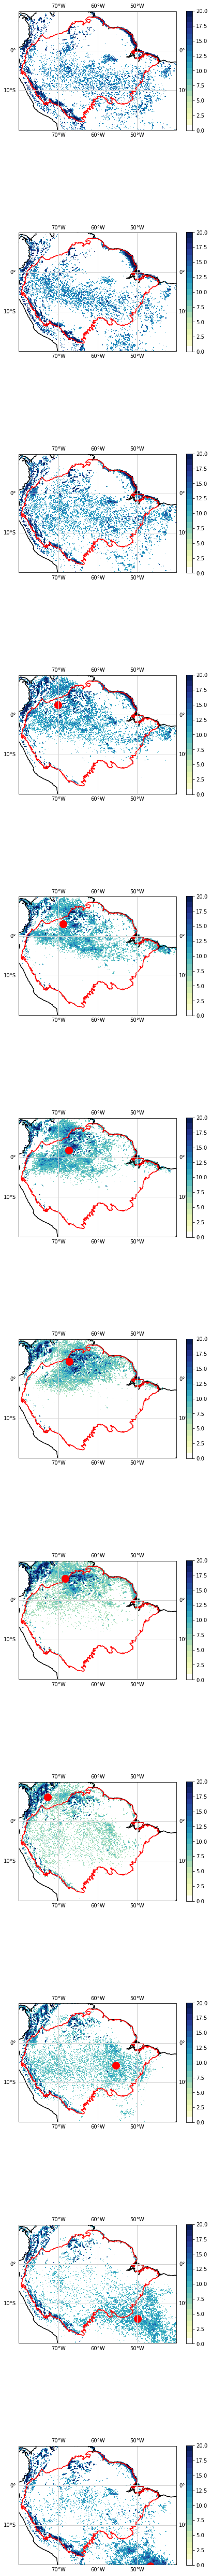

In [65]:
#plot_maps(pr_ctl_land, -40, 20, -100, -30, vmin=0, vmax=20)
plot_maps(pr_ctl_land_q80_area, -25, 15, -85, -35, YlGnBu_new, sam_ctl_loni, sam_ctl_lati, vmin=0, vmax=20)

In [71]:
import cartopy.feature as cfeature
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

def plot_diff_maps(dataset, lat_min, lat_max, lon_min, lon_max, cmap, vmin=None, vmax=None):
    num_times = dataset.shape[0]
    
    proj = ccrs.PlateCarree(central_longitude=180) # Create Mollweide projections
    
    minlon = lon_min + 5 + 180 #on
    maxlon = lon_max - 5 + 180 #on
    
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(24, 18), subplot_kw={'projection': proj}) # horizontal, vertical

    for i in range(3):
      for j in range(4):
          dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
          AMZ_BD = dset_bd.AMAZON_BIOMES
        
          ax = axs[i,j]
          ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],proj) #on
          ax.coastlines(resolution='50m', linewidth=1.5, color='black')
          gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray',
                        xlocs=range(-180,180,20), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
          gl.xformatter = LONGITUDE_FORMATTER
          gl.yformatter = LATITUDE_FORMATTER
          gl.xlabel_style, gl.ylabel_style = {'fontsize': 25}, {'fontsize': 25}
          # manipulate `gridliner` object
          gl.xlabels_top = False
          gl.xlabels_bottom = False
          gl.ylabels_right = False
          gl.ylabels_left = False
          gl.xlines = False
          gl.ylines = False
    
          #im = ax.imshow(dataset[i], cmap=YlGnBu_new, vmin=vmin, vmax=vmax, proj)
          im = dataset[4*i+j].plot(ax=ax,
                      transform=ccrs.PlateCarree(),
                      cmap=cmap,
                      vmin=vmin,
                      vmax=vmax,
                      add_colorbar=False
                      )
          ax.set_title(f"{months[3*i+j]}")
          ax.set_xlabel("Longitude")
          ax.set_ylabel("Latitude")
        #ax.gridlines(linestyle='--', linewidth=0.5)
        #axs[i].set_xticks(np.arange(0, 361, 60))
        #axs[i].set_yticks(np.arange(-90, 91, 30))
        #ax.grid(True, linestyle='--', linewidth=0.5)
        #ax.add_feature(cfeature.COASTLINE)
          #cbar = fig.colorbar(im, ax=axs[i], shrink=0.5)
          
          kw = {'levels':[-1], 'colors':['red'], 'linestyles':['solid']}
          plot_bd = AMZ_BD.plot.contour( 
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      **kw
                     )

    plt.tight_layout()
    plt.show()


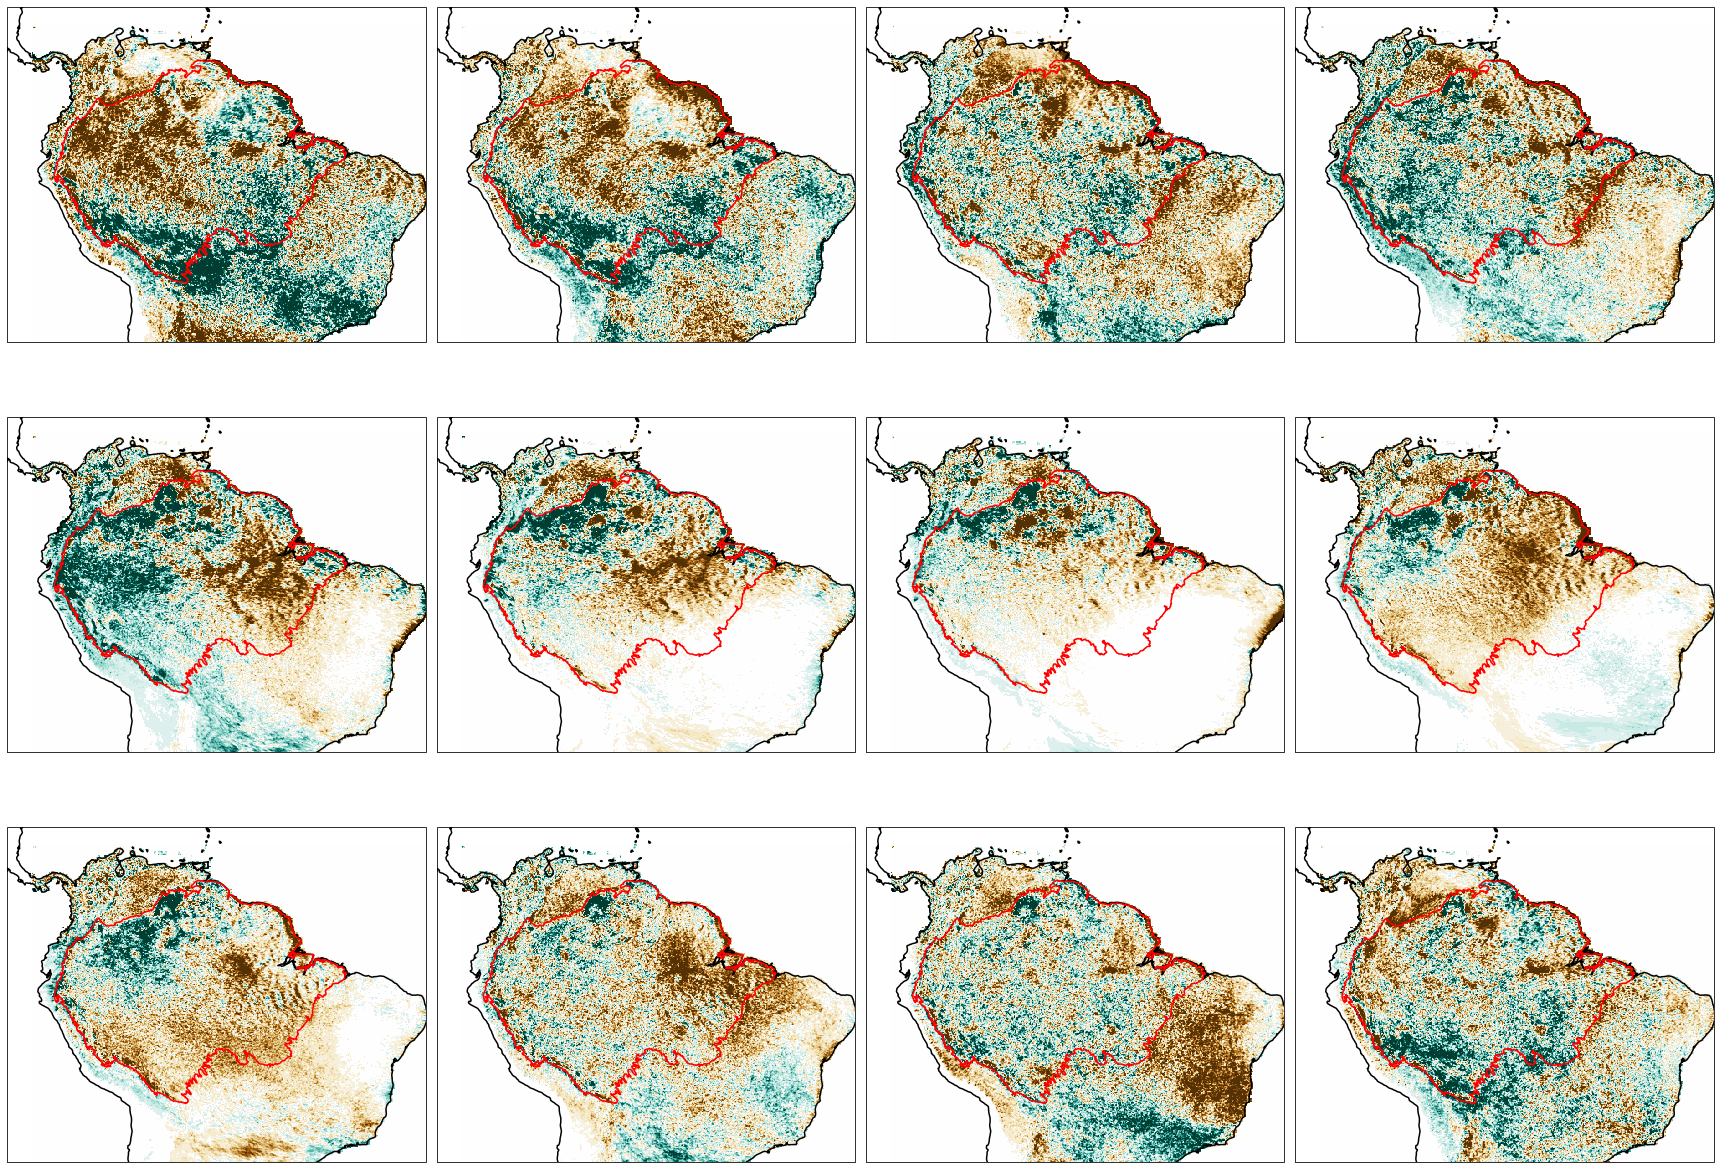

In [72]:
plot_diff_maps(pr_def_land_month-pr_ctl_land_month, -30, 20, -90, -30, BrBG_new, vmin=-5, vmax=5)

# Make the dataset for the dots

**Set up the structure**

In [28]:
s = ndimage.generate_binary_structure(2,2)

_South America_ [data,stats,labels_n,indices_n,sum_area,meanp,threshold,area_min] - lat=slice(-30,13),lon=slice(-82,-30) 

In [50]:
# individual years
sam_ctl_stats =  [object_id(pr_ctl_land_month[i,:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),0.1,0.1,s,\
                                     pr_ctl_land_q80[i].values,[500*500]) for i in range(pr_ctl_land_q80.size)]

sam_def_stats =  [object_id(pr_def_land_month[i,:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),0.1,0.1,s,\
                                     pr_def_land_q80[i].values,[500*500]) for i in range(pr_def_land_q80.size)]

In [ ]:
# individual years
sam_ctl_stats =  [object_id(pr_ctl_land[i,:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),0.1,0.1,s,\
                                     pr_ctl_land_q80[i].values,[500*500]) for i in range(pr_ctl_land_q80.size)]

sam_def_stats =  [object_id(pr_def_land[i,:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),0.1,0.1,s,\
                                     pr_def_land_q80[i].values,[500*500]) for i in range(pr_def_land_q80.size)]

In [66]:
# seasonal mean # p80, [500*500]; p90, [400:400]
sam_ctl_stats_season =  [object_id(season_pr_ctl_2[i,:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),0.1,0.1,s,\
                                     pr_ctl_q80[i].values,[300*300]) for i in range(pr_ctl_q80.size)]

sam_def_stats_season =  [object_id(season_pr_def_2[i,:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),0.1,0.1,s,\
                                     pr_def_q80[i].values,[300*300]) for i in range(pr_def_q80.size)]

In [59]:
# icon - November
sam_ctl_nov_stats =  [object_id(pr_ctl_nov[i,:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),0.1,0.1,s,\
                                     pr_ctl_nov_q80[i].values,[500*500]) for i in range(pr_ctl_nov_q80.size)]

In [ ]:
# every year and month
sam_ctl_stats_yr =  [
    [
        object_id(
            pr_ctl_land_year.isel(year=j, month=i).sel(lat=slice(-30,13),lon=slice(-82,-30)),
            0.1,0.1,s,
            pr_ctl_land_yr_q80.isel(year=j, month=i).values,
            [500*500]) 
        for i in range(12)
    ]
    for j in range(3)
]

In [43]:
print(np.shape(sam_ctl_stats_season))
print(np.shape(sam_ctl_stats))

(12, 2)


In [118]:
# imerge centroid yearly mean
#pr_imerg_land_mean = pr_imerg_land_month.transpose('month','lat','lon')
sam_imerg_mean_stats =  [object_id(pr_imerg_land_month[i,:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),0.1,0.1,s,\
                                     pr_imerg_land_q80[i].values,[500*500]) for i in range(pr_imerg_land_q80.size)]

In [32]:
sam_imerg_nov_stats =  [object_id(imerg_nov_month[i,:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),0.1,0.1,s,\
                                     imerg_nov_month_q80[i].values,[500*500]) for i in range(imerg_nov_month_q80.size)]

In [ ]:
# imerge centroid 20years of monthly mean
#pr_imerg_land = pr_imerg_land.transpose("year",'month','lat','lon')

sam_imerg_stats = [
    [
        object_id(
            pr_imerg_land.isel(year=j, month=i)[:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),
            0.1, 0.1, s,
            pr_imerg_land_q80.isel(year=j, month=i).values,
            [500 * 500]
        )
        for i in range(pr_imerg_land_q80.isel(year=0).size)
    ]
    for j in range(20)
]


In [ ]:
# imerge centroid 20years of concat_dimly mean
#pr_imerg_land = pr_imerg_land.transpose("year",'season','lat','lon')

sam_imerg_stats = [
    [
        object_id(
            season_pr_imerg.isel(year=j, concat_dim=i)[:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),
            0.1, 0.1, s,
            pr_imerg_q80.isel(year=j, concat_dim=i).values,
            [500 * 500]
        )
        for i in range(3)
    ]
    for j in range(20)
]


**Extract the area**

In [120]:
sam_ctl_area = [sam_ctl_stats[i][0][0][0] for i in range(pr_ctl_land_q80.size)]
sam_def_area = [sam_def_stats[i][0][0][0] for i in range(pr_def_land_q80.size)]

In [67]:
sam_ctl_season_area = [sam_ctl_stats_season[i][0][0][0] for i in range(3)]
sam_def_season_area = [sam_def_stats_season[i][0][0][0] for i in range(3)]

In [ ]:
sam_imerg_mean_area = [sam_imerg_mean_stats[i][0][0][0] for i in range(pr_imerg_land_q80.size)]

In [34]:
# november only
sam_imerg_nov_mean_area = [sam_imerg_nov_stats[i][0][0][0] for i in range(imerg_nov_month_q80.size)]

In [43]:
sam_imerg_area = [[sam_imerg_stats[i][j][0][0][0] for j in range(3)] for i in range(20)]

**Extract the longitude**

In [122]:
sam_ctl_loni = [sam_ctl_stats[i][0][0][-1] for i in range(pr_ctl_land_q80.size)]
sam_def_loni = [sam_def_stats[i][0][0][-1] for i in range(pr_def_land_q80.size)]

In [68]:
sam_ctl_season_loni = [sam_ctl_stats_season[i][0][0][-1] for i in range(3)]
sam_def_season_loni = [sam_def_stats_season[i][0][0][-1] for i in range(3)]

In [60]:
# November only
sam_ctl_nov_loni = [sam_ctl_nov_stats[i][0][0][-1] for i in range(pr_ctl_nov_q80.size)]

In [123]:
sam_imerg_mean_loni = [sam_imerg_mean_stats[i][0][0][-1] for i in range(pr_imerg_land_q80.size)]

In [35]:
# November only
sam_imerg_nov_mean_loni = [sam_imerg_nov_stats[i][0][0][-1] for i in range(imerg_nov_month_q80.size)]

In [46]:
sam_imerg_loni = [[sam_imerg_stats[i][j][0][0][-1] for j in range(3)] for i in range(20)]

**Extract the latitude**

In [124]:
sam_ctl_lati = [sam_ctl_stats[i][0][0][-2] for i in range(pr_ctl_land_q80.size)]
sam_def_lati = [sam_def_stats[i][0][0][-2] for i in range(pr_ctl_land_q80.size)]

In [69]:
sam_ctl_season_lati = [sam_ctl_stats_season[i][0][0][-2] for i in range(3)]
sam_def_season_lati = [sam_def_stats_season[i][0][0][-2] for i in range(3)]

In [61]:
# November
sam_ctl_nov_lati = [sam_ctl_nov_stats[i][0][0][-2] for i in range(3)]

In [125]:
sam_imerg_mean_lati = [sam_imerg_mean_stats[i][0][0][-2] for i in range(pr_imerg_land_q80.size)]

In [36]:
# November only
sam_imerg_nov_mean_lati = [sam_imerg_nov_stats[i][0][0][-2] for i in range(imerg_nov_month_q80.size)]

In [49]:
sam_imerg_lati = [[sam_imerg_stats[i][j][0][0][-2] for j in range(3)] for i in range(20)]

**Extract the Precipitation**

In [52]:
sam_ctl_intensity = [sam_ctl_stats[i][0][0][2] for i in range(3)]
sam_def_intensity = [sam_def_stats[i][0][0][2] for i in range(3)]

In [187]:
sam_ctl_season_intensity = [sam_ctl_stats_season[i][0][0][2] for i in range(3)]
sam_def_season_intensity = [sam_def_stats_season[i][0][0][2] for i in range(3)]

In [53]:
sam_imerg_mean_intensity = [sam_imerg_mean_stats[i][0][0][2] for i in range(pr_imerg_land_q80.size)]

In [37]:
# November only
sam_imerg_nov_mean_intensity = [sam_imerg_nov_stats[i][0][0][2] for i in range(imerg_nov_month_q80.size)]

In [148]:
sam_imerg_intensity = [[sam_imerg_stats[i][j][0][0][2] for j in range(3)] for i in range(20)]

**Extract the Mean PR**

In [54]:
sam_ctl_precip = [sam_ctl_stats[i][0][0][1] for i in range(3)]
sam_def_precip = [sam_def_stats[i][0][0][1] for i in range(3)]

In [188]:
sam_ctl_season_precip = [sam_ctl_stats_season[i][0][0][1] for i in range(3)]
sam_def_season_precip = [sam_def_stats_season[i][0][0][1] for i in range(3)]

In [55]:
sam_imerg_mean_precip = [sam_imerg_mean_stats[i][0][0][1] for i in range(pr_imerg_land_q80.size)]

In [53]:
sam_precip_imerg = [[sam_imerg_stats[i][j][0][0][1] for j in range(3)] for i in range(20)]

**plot on the map**

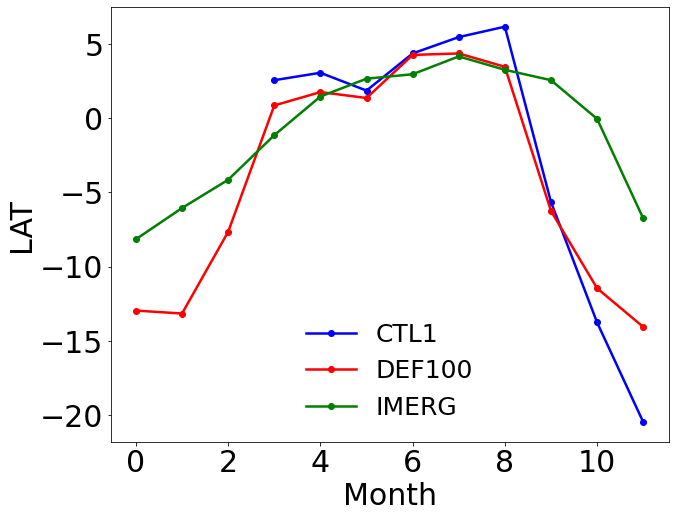

In [56]:
import datetime
fig = plt.figure(figsize=(10,8))
#fig.suptitle('Amazon Precipitation', size=30)
plt.plot(sam_ctl_lati,'o-b',label="CTL1",linewidth=2.5)
#plt.plot(sam2_lati,'o-g',label="CTL2",linewidth=2.5)
plt.plot(sam_def_lati,'o-r',label="DEF100",linewidth=2.5)
plt.plot(sam_imerg_mean_lati,'o-g',label="IMERG",linewidth=2.5)

plt.ylabel('LAT',fontsize=30)
plt.xlabel('Month',fontsize=30)
#plt.xlim([datetime.date(2020, 1, 23),datetime.date(2021, 1, 31)])
#plt.ylim(0,25)
plt.xticks(fontsize=30,rotation=0)
plt.yticks(fontsize=30)
plt.legend(fontsize=25, frameon=False)

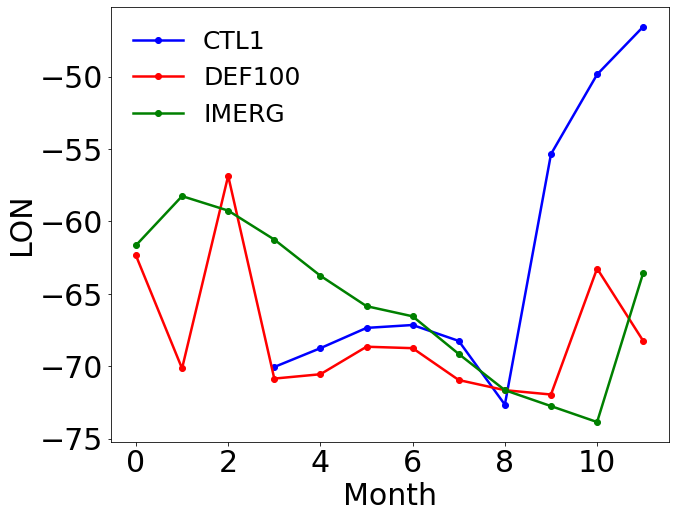

In [57]:
import datetime
fig = plt.figure(figsize=(10,8))
#fig.suptitle('Amazon Precipitation', size=30)
plt.plot(sam_ctl_loni,'o-b',label="CTL1",linewidth=2.5)
#plt.plot(sam2_loni,'o-g',label="CTL2",linewidth=2.5)
plt.plot(sam_def_loni,'o-r',label="DEF100",linewidth=2.5)
plt.plot(sam_imerg_mean_loni,'o-g',label="IMERG",linewidth=2.5)

plt.ylabel('LON',fontsize=30)
plt.xlabel('Month',fontsize=30)
#plt.xlim([datetime.date(2020, 1, 23),datetime.date(2021, 1, 31)])
#plt.ylim(0,25)
plt.xticks(fontsize=30,rotation=0)
plt.yticks(fontsize=30)
plt.legend(fontsize=25, frameon=False)

In [70]:
print(sam_ctl_season_lati)
print(sam_ctl_season_loni)
print(sam_def_season_lati)
print(sam_def_season_loni)

[array([2.65]), array([-17.75]), array([4.85])]
[array([-69.05]), array([-66.75]), array([-68.85])]
[array([1.35]), array([-12.55]), array([4.15])]
[array([-70.85]), array([-63.25]), array([-70.85])]


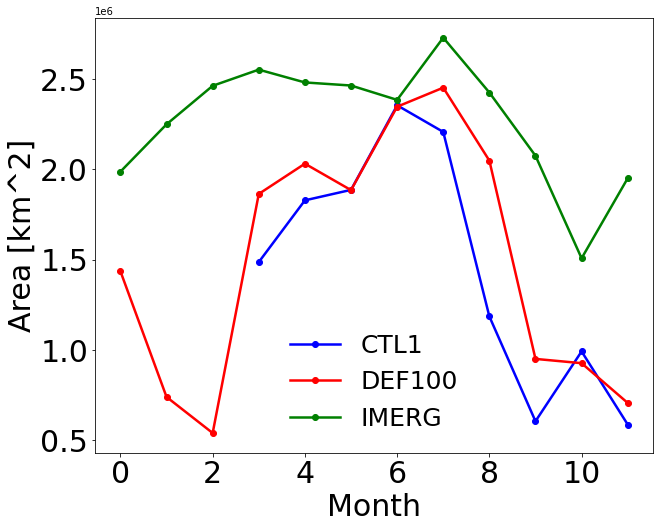

In [59]:
import datetime
fig = plt.figure(figsize=(10,8))
#fig.suptitle('Amazon Precipitation', size=30)
plt.plot(np.concatenate(sam_ctl_area)/1000000,'o-b',label="CTL1",linewidth=2.5)
#plt.plot(np.concatenate(sam2_area)/1000000,'o-g',label="CTL2",linewidth=2.5)
plt.plot(np.concatenate(sam_def_area)/1000000,'o-r',label="DEF100",linewidth=2.5)
plt.plot(np.concatenate(sam_imerg_mean_area)/1000000,'o-g',label="IMERG",linewidth=2.5)

plt.ylabel('Area [km^2]',fontsize=30)
plt.xlabel('Month',fontsize=30)
#plt.xlim([datetime.date(2020, 1, 23),datetime.date(2021, 1, 31)])
#plt.ylim(0,25)
plt.xticks(fontsize=30,rotation=0)
plt.yticks(fontsize=30)
plt.legend(fontsize=25, frameon=False)

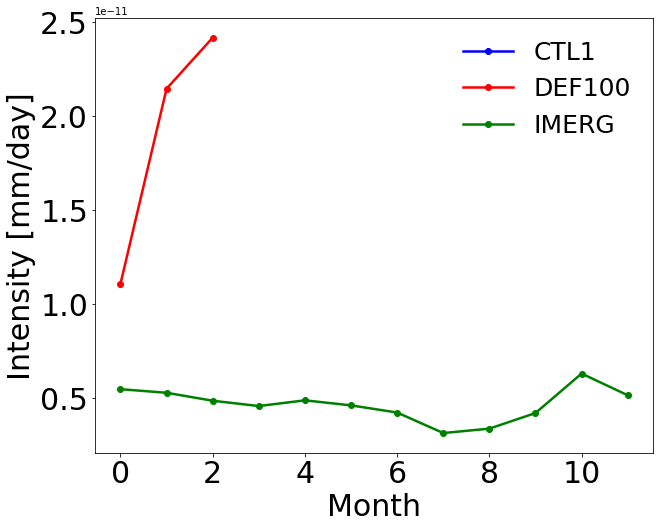

In [60]:
import datetime
fig = plt.figure(figsize=(10,8))
#fig.suptitle('Amazon Precipitation', size=30)
plt.plot(sam_ctl_intensity,'o-b',label="CTL1",linewidth=2.5)
#plt.plot(sam2_intensity,'o-g',label="CTL2",linewidth=2.5)
plt.plot(sam_def_intensity,'o-r',label="DEF100",linewidth=2.5)
plt.plot(sam_imerg_mean_intensity,'o-g',label="IMERG",linewidth=2.5)

plt.ylabel('Intensity [mm/day]',fontsize=30)
plt.xlabel('Month',fontsize=30)
#plt.xlim([datetime.date(2020, 1, 23),datetime.date(2021, 1, 31)])
#plt.ylim(0,25)
plt.xticks(fontsize=30,rotation=0)
plt.yticks(fontsize=30)
plt.legend(fontsize=25, frameon=False)

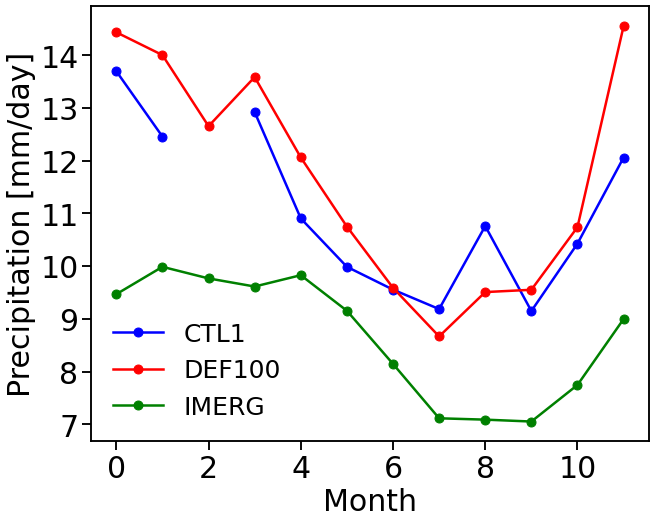

In [146]:
import datetime
fig = plt.figure(figsize=(10,8))
#fig.suptitle('Amazon Precipitation', size=30)
plt.plot(sam_ctl_precip,'o-b',label="CTL1",linewidth=2.5)
#plt.plot(sam2_precip,'o-g',label="CTL2",linewidth=2.5)
plt.plot(sam_def_precip,'o-r',label="DEF100",linewidth=2.5)
plt.plot(sam_imerg_mean_precip,'o-g',label="IMERG",linewidth=2.5)

plt.ylabel('Precipitation [mm/day]',fontsize=30)
plt.xlabel('Month',fontsize=30)
#plt.xlim([datetime.date(2020, 1, 23),datetime.date(2021, 1, 31)])
#plt.ylim(0,25)
plt.xticks(fontsize=30,rotation=0)
plt.yticks(fontsize=30)
plt.legend(fontsize=25, frameon=False)

### IMERGE: Calculate standard deviation

_standard deviation_

In [77]:
print(np.shape(sam_imerg_lati)) 
std_imerg_lati = np.std(sam_imerg_lati, axis=0)
print(np.shape(std_imerg_lati))
print(std_imerg_lati)

(20, 3, 1)
(3, 1)
[[0.85022069]
 [1.48130919]
 [0.333017  ]]


In [78]:
std_imerg_loni = np.std(sam_imerg_loni, axis=0)
print(np.shape(std_imerg_loni))
print(std_imerg_loni)

(3, 1)
[[0.65289681]
 [2.28234515]
 [0.6147362 ]]


_mean_

In [79]:
mean_imerg_lati = np.mean(sam_imerg_lati, axis=0)
mean_imerg_loni = np.mean(sam_imerg_loni, axis=0)

In [51]:
print(np.shape(mean_imerg_lati))
print(mean_imerg_lati)
print(mean_imerg_loni)

(3, 1)
[[-1.27500041]
 [-9.21499996]
 [ 2.73999934]]
[[-65.56499729]
 [-59.62000122]
 [-68.13999748]]


# 2d Map

In [14]:
BrBG_new = Tools.colormap_create('BrBG',21,10,11)
BrBG_w_new = Tools.colormap_create('BrBG',21,9,12)
BrBG_r_new = Tools.colormap_create('BrBG_r',21,9,12)

_load full precipitation and evaporation for plotting wider area (-60, 20; -100;-20)_

_precipitation_

In [15]:
# -60, 20, -100, -20
times = ['2020-01-01','2022-12-31']
var = 'pr'
time_mean = '1MS'
    
pr_ctl_land = Tools.time_mean_model(file_icon_pp,times,time_mean,var,[-60,20],[-100,-20],'land')  #file_icon_ua,times,time_mean,var_ua,[-60,20],[-100,-20],'trop'

In [16]:
pr_def_land = Tools.time_mean_model(file_def_pp,times,time_mean,var,[-60,20],[-100,-20],'land')

In [67]:
pr_imerg_land= time_mean_imerg_multi(file_imerg,[-30,13],[-82,-30],'land') # 21 years

In [69]:
pr_ctl_month = pr_ctl_land.sel(time=slice('2020-02-01','2022-12-31')).groupby('time.month').mean('time')*24*3600
pr_def_month = pr_def_land.sel(time=slice('2020-02-01','2022-12-31')).groupby('time.month').mean('time')*24*3600

In [69]:
pr_imerg_month = pr_imerg_land.sel(time=slice('2001-01-01','2020-12-31')).groupby('time.month').mean('time')

In [66]:
pr_ctl_avg = pr_ctl_month.mean('month')
pr_def_avg = pr_def_month.mean('month')

In [70]:
pr_imerg_avg = pr_imerg_month.mean('month')

In [70]:
pr_ctl_wet = pr_ctl_month.where(pr_ctl_month.month.isin([1,2,12]), drop=True).mean("month")
pr_def_wet = pr_def_month.where(pr_def_month.month.isin([1,2,12]), drop=True).mean("month")

pr_ctl_dry = pr_ctl_month.where(pr_ctl_month.month.isin([7,8,9]), drop=True).mean("month")
pr_def_dry = pr_def_month.where(pr_def_month.month.isin([7,8,9]), drop=True).mean("month")

#pr_ctl_trans = pr_ctl_month.where(pr_ctl_month.month.isin([3,4,5,10,11]), drop=True).mean("month")
#pr_def_trans = pr_def_month.where(pr_def_month.month.isin([3,4,5,10,11]), drop=True).mean("month")

_evaporation_

In [35]:
glob_pattern_3d1 = 'ctl_daily_hfls_202'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/scratch/m/m300948/test_04/hfls')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
hfls_icon_pp = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

times = ['2020-02-01','2022-12-31']
var = 'hfls'
hfls_ctl_land = Tools.time_mean_model(hfls_icon_pp,times,time_mean,var,[-60,20],[-100,-20],'land')
ev_ctl_land = hfls_ctl_land/28.94 #/3600/24

In [36]:
glob_pattern_3d1 = 'def_daily_hfls_202'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/scratch/m/m300948/def_100/hfls')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
hfls_def_pp = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

times = ['2020-02-01','2022-12-31']
var = 'hfls'
hfls_def_land = Tools.time_mean_model(hfls_def_pp,times,time_mean,var,[-60,20],[-100,-20],'land')
ev_def_land = hfls_def_land/28.94 #/3600/24

In [37]:
ev_ctl_month = ev_ctl_land.sel(time=slice('2020-02-01','2022-12-31')).groupby('time.month').mean('time')
ev_def_month = ev_def_land.sel(time=slice('2020-02-01','2022-12-31')).groupby('time.month').mean('time')

In [56]:
ev_ctl_wet = ev_ctl_month.where(ev_ctl_month.month.isin([1,2,12]), drop=True).mean("month")
ev_def_wet = ev_def_month.where(ev_def_month.month.isin([1,2,12]), drop=True).mean("month")

ev_ctl_dry = ev_ctl_month.where(ev_ctl_month.month.isin([7,8,9]), drop=True).mean("month")
ev_def_dry = ev_def_month.where(ev_def_month.month.isin([7,8,9]), drop=True).mean("month")

#ev_ctl_trans = ev_ctl_month.where(ev_ctl_month.month.isin([3,4,5,10,11]), drop=True).mean("month")
#ev_def_trans = ev_def_month.where(ev_def_month.month.isin([3,4,5,10,11]), drop=True).mean("month")

In [71]:
convg_ctl_wet = pr_ctl_wet + ev_ctl_wet
convg_def_wet = pr_def_wet + ev_def_wet

convg_ctl_dry = pr_ctl_dry + ev_ctl_dry
convg_def_dry = pr_def_dry + ev_def_dry

#convg_ctl_trans = pr_ctl_trans + ev_ctl_trans
#convg_def_trans = pr_def_trans + ev_def_trans

In [40]:
# For waning cresecnt
pr_ctl_all = pr_ctl_month.where(pr_ctl_month.month.isin([1,2,7,8,9,12]), drop=True).mean("month")
pr_def_all = pr_def_month.where(pr_def_month.month.isin([1,2,7,8,9,12]), drop=True).mean("month")

_plot figure with the objection dots_

In [81]:
def plot_data_amz_bd(data, colormap, extend, varmin, varmax, space, 
                     obj_1 , lati_1, loni_1, colors_1, obj_2, lati_2, loni_2, colors_2, obj_3, lati_3, loni_3, std_lat_3, std_lon_3, colors_3,
                     lat_min, lat_max, int_lat, lon_min, lon_max, int_lon,
                     cb_title, title):
    
    # Amazon basin contour
    dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
    AMZ_BD = dset_bd.AMAZON_BIOMES
    
    proj = ccrs.PlateCarree(central_longitude=180) # Create Mollweide projections
    fig  = plt.figure(figsize=(8, 10))
    ax = fig.add_subplot(111, projection=proj)
    
    minlon = lon_min + 5 + 180 #on
    maxlon = lon_max - 5 + 180 #on
    
    ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],proj) #on
    ax.coastlines(resolution='50m', linewidth=1.5, color='black')
    
    # gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray',
                        xlocs=range(-180,180,20), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 25}, {'fontsize': 25}
    # manipulate `gridliner` object
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlines = False
    gl.ylines = False

    # plot data
    bounds = np.linspace(varmin,varmax, space)
    plot = data.plot(
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      cmap=colormap,
                      vmin=varmin,
                      vmax=varmax,
                     # bounds,
                     # cbar_kwargs={'label': 'Surface Temperature [K]',
                     #              'extend': 'both',
                     #              'shrink': .5,
                     #              'orientation': 'horizontal'},
                      add_colorbar=False,
                      levels=bounds, # to fill up the white space
                      extend=extend
                     )
   
    kw = {'levels':[-1], 'colors':['red'], 'linestyles':['solid']}
    plot_bd = AMZ_BD.plot.contour( 
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      **kw
                     )
    
    # bounds = np.linspace(varmin,varmax, space)
    cb = plt.colorbar(plot, orientation="horizontal", fraction=0.05, pad=0.10, extend=extend,ticks=bounds, boundaries=bounds)
    cb.ax.tick_params(labelsize=25)
    cb.ax.set_xticklabels(bounds,rotation=270)
    cb.set_label(label=cb_title, size=25)
    
    # plot object centroid (dots)
    if obj_1 == True:
        plt.scatter(x=loni_1, y=lati_1, transform=ccrs.PlateCarree(), color=colors_1, marker='o', s=600, edgecolors='black', linewidth=3) #colors_b[i]
        
    if obj_2 == True:
        plt.scatter(x=loni_2, y=lati_2, transform=ccrs.PlateCarree(), color=colors_2, marker='o', s=600, edgecolors='black', linewidth=3) #colors_b[i]
        
    if obj_3 == True:
        plt.errorbar(x=loni_3, y=lati_3, xerr=std_lon_3, yerr=std_lat_3, transform=ccrs.PlateCarree(), color='black') #colors_b[i]
        plt.scatter(x=loni_3, y=lati_3, transform=ccrs.PlateCarree(), color=colors_3, marker="o", s=600,  edgecolors='black', linewidth=3) #colors_g
    
    ax.set_title(title, y=1.1, fontsize=25)

In [26]:
mean_imerg_lati = [0,0,0] 
mean_imerg_loni = [0,0,0]
std_imerg_lati = [0,0,0] 
std_imerg_loni = [0,0,0]

In [27]:
sam_ctl_lati = [0,0,0]
sam_ctl_loni = [0,0,0]
sam_def_lati = [0,0,0]
sam_def_loni = [0,0,0]

In [29]:
# analysis_pr_ctl, wet_pr_ctl, dry_pr_ctl
sam_ctl_season_lati = [1.75,-17.75, 4.85]
sam_def_season_lati = [1.35, -12.55, 4.15]
sam_ctl_season_loni = [-70.15, -66.75, -68.85]
sam_def_season_loni = [-72.15, -63.25, -70.85]

In [28]:
# mj_pr_ctl, wet_pr_ctl, dry_pr_ctl
sam_ctl_season_lati = [2.75,-17.75, 4.85]
sam_def_season_lati = [1.95, -12.55, 4.15]
sam_ctl_season_loni = [-68.85, -66.75, -68.85]
sam_def_season_loni = [-70.25, -63.25, -70.85]

In [77]:
cmap = matplotlib.cm.get_cmap('PiYG')
left = cmap(0.0)
right = cmap(1.0)

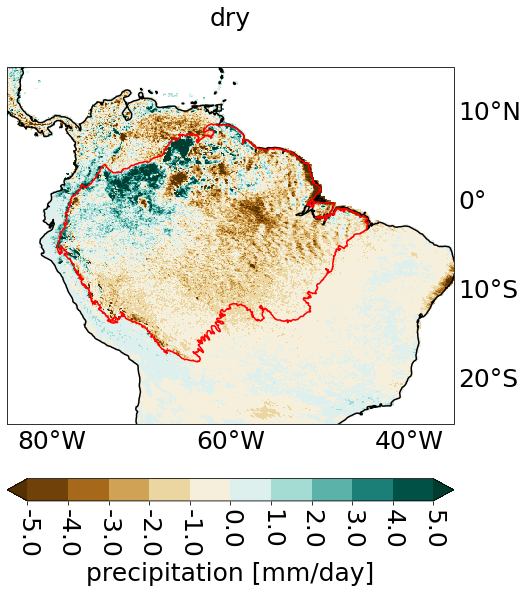

In [72]:
plot_data_amz_bd(pr_def_dry-pr_ctl_dry, BrBG_new, 'both', -5, 5, 11, 
                     False , sam_ctl_lati[2], sam_ctl_loni[2], 'blue', False, sam_def_lati[2], sam_def_loni[2], 'deeppink', False, mean_imerg_lati[0], mean_imerg_loni[0], 
                     std_imerg_lati[0], std_imerg_loni[0], 'green',
                     -30, 20, 5, -90, -30, 10,
                     'precipitation [mm/day]','dry')

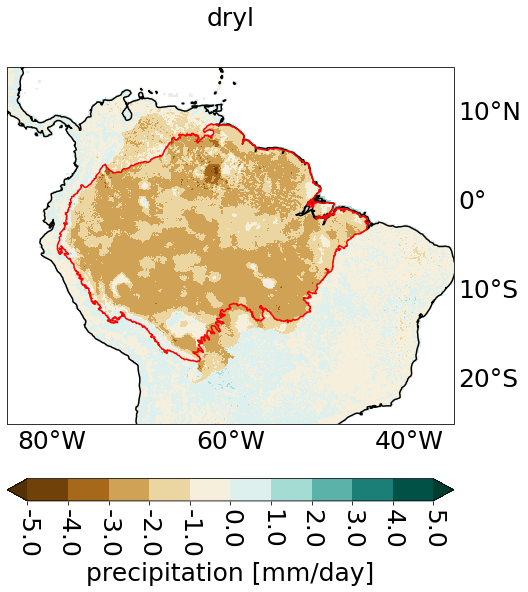

In [47]:
plot_data_amz_bd(-ev_def_wet+ev_ctl_wet, BrBG_new, 'both', -5, 5, 11, 
                     False , sam_ctl_lati[2], sam_ctl_loni[2], 'blue', False, sam_def_lati[2], sam_def_loni[2], 'deeppink', False, mean_imerg_lati[0], mean_imerg_loni[0], 
                     std_imerg_lati[0], std_imerg_loni[0], 'green',
                     -30, 20, 5, -90, -30, 10,
                     'precipitation [mm/day]','dryl')

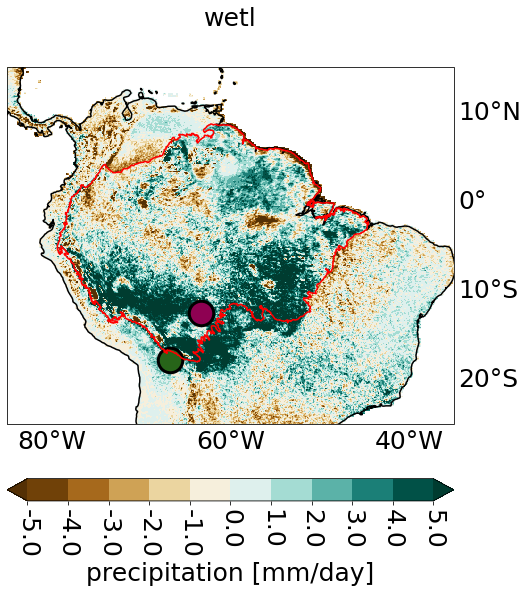

In [83]:
plot_data_amz_bd(convg_def_wet-convg_ctl_wet, BrBG_new, 'both', -5, 5, 11, 
                     True , sam_ctl_season_lati[1], sam_ctl_season_loni[1], right, True, sam_def_season_lati[1], sam_def_season_loni[1], left, False, mean_imerg_lati[0], mean_imerg_loni[0], 
                     std_imerg_lati[0], std_imerg_loni[0], 'green',
                     -30, 20, 5, -90, -30, 10,
                     'precipitation [mm/day]','wetl')

In [44]:
plot_data_amz_bd(season_pr_def.isel(concat_dim=1)-season_pr_ctl.isel(concat_dim=1), BrBG_new, 'both', -5, 5, 11, 
                     True , sam_ctl_lati[2], sam_ctl_loni[2], 'blue', True, sam_def_lati[2], sam_def_loni[2], 'deeppink', False, mean_imerg_lati[0], mean_imerg_loni[0], 
                     std_imerg_lati[0], std_imerg_loni[0], 'green',
                     -30, 20, 5, -90, -30, 10,
                     'precipitation [mm/day]','Annual mean precipitation')

NameError: name 'season_pr_def' is not defined

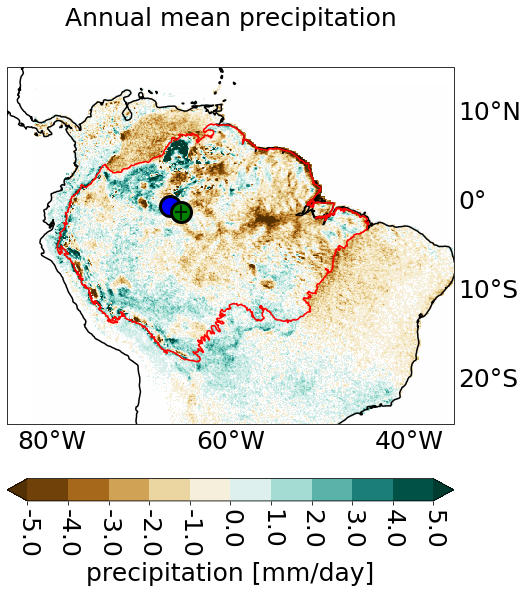

In [84]:
plot_data_amz_bd(season_pr_def.isel(concat_dim=0)-season_pr_ctl.isel(concat_dim=0), BrBG_new, 'both', -5, 5, 11, 
                     True , sam_ctl_lati[0], sam_ctl_loni[0], 'blue', False, sam_def_lati[2], sam_def_loni[2], 'deeppink', True, mean_imerg_lati[0], mean_imerg_loni[0], 
                     std_imerg_lati[0], std_imerg_loni[0], 'green',
                     -30, 20, 5, -90, -30, 10,
                     'precipitation [mm/day]','Annual mean precipitation')

In [98]:
pr_ctl_avg_interp = pr_ctl_avg.interp_like(pr_imerg_avg)
print(pr_ctl_avg_interp.shape)

(430, 520)


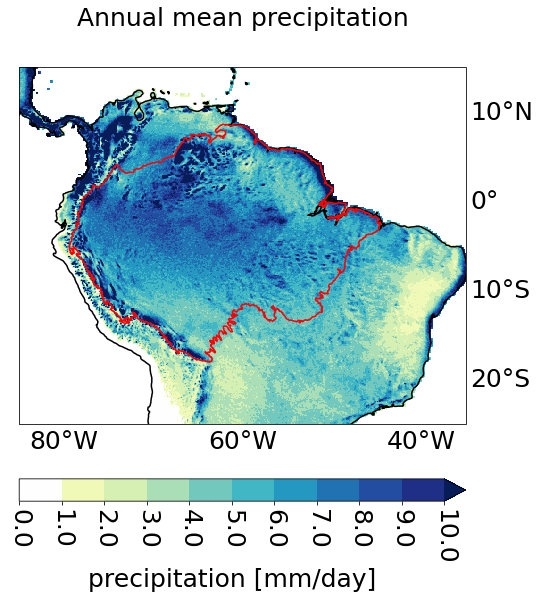

In [101]:
plot_data_amz_bd(pr_ctl_avg, YlGnBu_new, 'max', 0, 10, 11, 
                     False , sam_ctl_lati[0], sam_ctl_loni[0], 'blue', False, sam_def_lati[2], sam_def_loni[2], 'deeppink', False, mean_imerg_lati[0], mean_imerg_loni[0], 
                     std_imerg_lati[0], std_imerg_loni[0], 'green',
                     -30, 20, 5, -90, -30, 10,
                     'precipitation [mm/day]','Annual mean precipitation')

In [61]:
cmap = matplotlib.cm.get_cmap('PiYG')
left = cmap(0.0)
right = cmap(1.0)

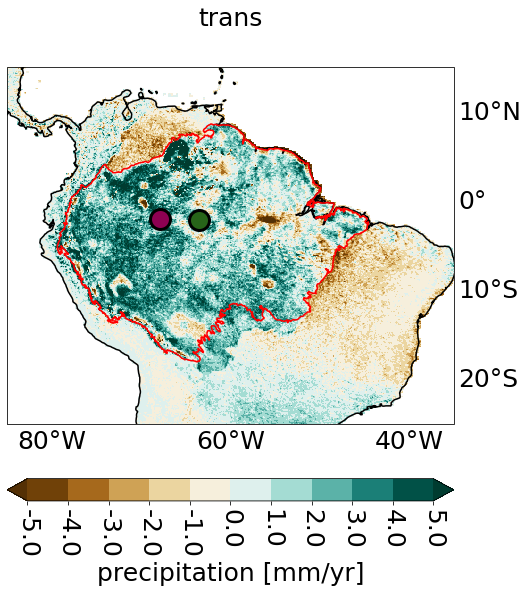

In [63]:
# trans, wet, trans
plot_data_amz_bd(convg_def_trans-convg_ctl_trans, BrBG_new, 'both', -5, 5, 11, 
                     True , sam_ctl_season_lati[0], sam_ctl_season_loni[0], right, True, sam_def_season_lati[0], sam_def_season_loni[0], left, False, mean_imerg_lati[0], mean_imerg_loni[0], 
                     std_imerg_lati[0], std_imerg_loni[0], 'green',
                     -30, 20, 5, -90, -30, 10,
                     'precipitation [mm/yr]','trans')

In [110]:
pr_def_dry

<xarray.DataArray 'pr' (lat: 0, lon: 0)>
array([], shape=(0, 0), dtype=float32)
Coordinates:
  * lon      (lon) float64 
  * lat      (lat) float64

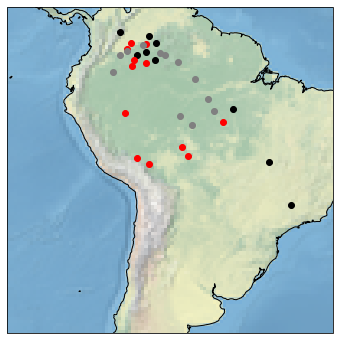

In [78]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.stock_img()
ax.coastlines()

lat1, lon1, lat2, lon2 = -40, -90, 10, -40
ax.set_extent([lat1, lon1, lat2, lon2], crs=ccrs.PlateCarree())
plt.scatter(x=sam_ctl_loni, y=sam_ctl_lati, c='black')
plt.scatter(x=sam_def_loni, y=sam_def_lati, c='red')
plt.scatter(x=sam_imerg_mean_loni, y=sam_imerg_mean_lati, c='grey')
#plt.errorbar(x=flat_loni_mean, y=flat_lati_mean, xerr=flat_loni_std, yerr=flat_lati_std)

plt.show()

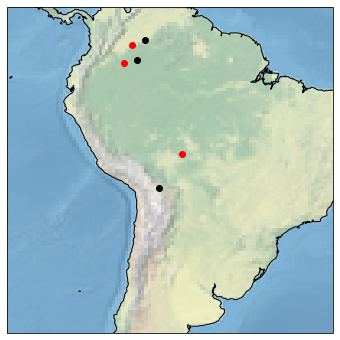

In [89]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.stock_img()
ax.coastlines()

lat1, lon1, lat2, lon2 = -40, -90, 10, -40
ax.set_extent([lat1, lon1, lat2, lon2], crs=ccrs.PlateCarree())
plt.scatter(x=sam_ctl_season_loni, y=sam_ctl_season_lati, c='black')
plt.scatter(x=sam_def_season_loni, y=sam_def_season_lati, c='red')
#plt.scatter(x=sam_imerg_mean_loni, y=sam_imerg_mean_lati, c='grey')
#plt.errorbar(x=flat_loni_mean, y=flat_lati_mean, xerr=flat_loni_std, yerr=flat_lati_std)

plt.show()

In [87]:
sam_ctl_loni_ss = list( sam_ctl_loni[i] for i in [0,1,6,7,8,11] )
sam_ctl_lati_ss = list( sam_ctl_lati[i] for i in [0,1,6,7,8,11] )
sam_def_loni_ss = list( sam_def_loni[i] for i in [0,1,6,7,8,11] )
sam_def_lati_ss = list( sam_def_lati[i] for i in [0,1,6,7,8,11] )
sam_imerg_loni_ss = list( sam_loni_mean_imerg[i] for i in [0,1,6,7,8,11] )
sam_imerg_lati_ss = list( sam_lati_mean_imerg[i] for i in [0,1,6,7,8,11] )

In [38]:
def obj_pr(ctl_loni, ctl_lati, def_loni, def_lati, lat_min, lat_max, lon_min, lon_max):
#def obj_pr(ctl_loni, ctl_lati, def_loni, def_lati, imerg_loni, imerg_lati, imerg_loni_std, imerg_lati_std, lat_min, lat_max, lon_min, lon_max):
#def obj_pr(imerg_loni, imerg_lati, lat_min, lat_max, lon_min, lon_max):
    dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
    AMZ_BD = dset_bd.AMAZON_BIOMES
    
    proj = ccrs.PlateCarree(central_longitude=180) # Create Mollweide projections
    fig  = plt.figure(figsize=(8, 10))
    ax = fig.add_subplot(111, projection=proj)
    #ax.stock_img()
    
    minlon = lon_min + 5 + 180 #on
    maxlon = lon_max - 5 + 180 #on
    
    #ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],proj) #on
    #ax.coastlines(resolution='50m', linewidth=1.5, color='black')
    #ax.gridlines(draw_labels=True, linewidth=1.0, color='lightgrey',
    #                    xlocs=range(-180,180,10), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
    
    ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],proj) #on
    ax.coastlines(resolution='50m', linewidth=1.5, color='black')
    
    # gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray',
                        xlocs=range(-180,180,20), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 25}, {'fontsize': 25}
    # manipulate `gridliner` object
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlines = False
    gl.ylines = False
    
    kw = {'levels':[-1], 'colors':['gray'], 'linestyles':['solid']}
    plot_bd = AMZ_BD.plot.contour( 
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      linewidth=0.5,
                      **kw
                     )
    #colors_r = ['#FFEBEB', '#FFD7D7', '#FFC3C3', '#FFAFAF', '#FF9B9B', '#FF7373', '#FF4B4B', '#FF1919', '#F00000', '#C80000', '#A00000', '#640000'] 
    #colors_b = ['#E1F6FF', '#CDF0FF', '#B9EBFF', '#A5E5FF', '#91E0FF', '#73D7FF', '#55CEFF', '#37C6FF', '#19BDFF', '#00ABF0', '#0072A0', '#004764']
    #colors_g = ['#E9F7F5', '#DAF2EF', '#CCECE7', '#BDE7E0', '#AEE2D9', '#91CDCB', '#74CCBD', '#55C3B1', '#3FB19E', '#359383', '#226056', '#153B35']
    
    # Same as Hans' color map
    colors_r = ['navy', 'navy', 'teal', 'teal', 'darkgreen', 'darkgreen', 'orange', 'orange', 'red', 'red', 'brown', 'brown'] 
    colors_b = ['navy', 'navy', 'teal', 'teal', 'darkgreen', 'darkgreen', 'orange', 'orange', 'red', 'red', 'brown', 'brown']
    
    colors_r_ss = ['#FFAA00', '#FF8800', '#FF6600', '#FF4400', '#F22000',  '#FF0000'] 
    colors_b_ss = ['#33FFFF', '#33DDFF', '#33AAFF', '#3377FF', '#3355FF',  '#3300FF']
    colors_g_ss = ['#00FF11', '#00DD11', '#00BB11', '#008811', '#006611',  '#003311']
    
    #plt.plot(ctl_loni, ctl_lati, transform=ccrs.PlateCarree(), color='cornflowerblue',ls='-')
    #plt.plot(def_loni, def_lati, transform=ccrs.PlateCarree(), color='pink', ls='--')
    #plt.plot(imerg_loni, imerg_lati, transform=ccrs.PlateCarree(), color='yellowgreen')
    
    plt.plot(ctl_loni, ctl_lati, transform=ccrs.PlateCarree(), color='black',ls='-', linewidth=2)
    plt.plot(def_loni, def_lati, transform=ccrs.PlateCarree(), color='black', ls='--', linewidth=2)
    
    for i in range(12):
        plt.scatter(x=ctl_loni[i], y=ctl_lati[i],transform=ccrs.PlateCarree(), facecolors='none', edgecolors=colors_b[i], marker='o', s=400, linewidth=2) #colors_b[i]
        plt.scatter(x=def_loni[i], y=def_lati[i],transform=ccrs.PlateCarree(), facecolors='none', edgecolors=colors_r[i], marker='s', s=400, linewidth=2) #colors_r[i]
        #plt.errorbar(x=imerg_loni[i], y=imerg_lati[i], xerr=imerg_loni_std[i], yerr=imerg_lati_std[i], transform=ccrs.PlateCarree(), color='#555555')
        #plt.scatter(x=imerg_loni[i], y=imerg_lati[i],transform=ccrs.PlateCarree(), color=colors_g[i], marker="^", s=200) #colors_g
        
    #fig.savefig('./obj_precip_wo_basin.png', transparent=True)

In [74]:
def obj_pr_imerg_only(ctl_loni, ctl_lati, def_loni, def_lati, lat_min, lat_max, lon_min, lon_max):
#def obj_pr(ctl_loni, ctl_lati, def_loni, def_lati, imerg_loni, imerg_lati, imerg_loni_std, imerg_lati_std, lat_min, lat_max, lon_min, lon_max):
#def obj_pr(imerg_loni, imerg_lati, lat_min, lat_max, lon_min, lon_max):
    dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
    AMZ_BD = dset_bd.AMAZON_BIOMES
    
    proj = ccrs.PlateCarree(central_longitude=180) # Create Mollweide projections
    fig  = plt.figure(figsize=(8, 10))
    ax = fig.add_subplot(111, projection=proj)
    #ax.stock_img()
    
    minlon = lon_min + 5 + 180 #on
    maxlon = lon_max - 5 + 180 #on
    
    #ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],proj) #on
    #ax.coastlines(resolution='50m', linewidth=1.5, color='black')
    #ax.gridlines(draw_labels=True, linewidth=1.0, color='lightgrey',
    #                    xlocs=range(-180,180,10), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
    
    ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],proj) #on
    ax.coastlines(resolution='50m', linewidth=1.5, color='black')
    
    # gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray',
                        xlocs=range(-180,180,20), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 25}, {'fontsize': 25}
    # manipulate `gridliner` object
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlines = False
    gl.ylines = False
    
    kw = {'levels':[-1], 'colors':['gray'], 'linestyles':['solid']}
    plot_bd = AMZ_BD.plot.contour( 
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      linewidth=0.5,
                      **kw
                     )

    colors_g = [
    '#E6F9E6', '#CCF2CC', '#B2ECB2', '#99E699', '#80E080', '#66D966', '#4DD24D', '#33CC33',
    '#1AC61A', '#00C000', '#00A600', '#008C00', '#007300', '#005900', '#004000', '#002600',
    '#001C00', '#001200', '#000900', '#000300'
    ]
    colors_b = ['#33FFFF', '#33DDFF', '#33AAFF']
    
    #plt.plot(ctl_loni, ctl_lati, transform=ccrs.PlateCarree(), color='cornflowerblue',ls='-')
    #plt.plot(def_loni, def_lati, transform=ccrs.PlateCarree(), color='pink', ls='--')
    #plt.plot(imerg_loni, imerg_lati, transform=ccrs.PlateCarree(), color='yellowgreen')
    
    #plt.plot(ctl_loni, ctl_lati, transform=ccrs.PlateCarree(), color='black',ls='-', linewidth=2)
    #plt.plot(def_loni, def_lati, transform=ccrs.PlateCarree(), color='black', ls='--', linewidth=2)
    
    for i in range(20):
        plt.scatter(x=ctl_loni[i], y=ctl_lati[i],transform=ccrs.PlateCarree(), facecolors='none', edgecolors='green', marker='o', s=400, linewidth=3) #colors_b[i]
    for j in range(3):
        plt.scatter(x=def_loni[j], y=def_lati[j],transform=ccrs.PlateCarree(), color='blue', marker='o', s=400, linewidth=2) #colors_r[i]
        #plt.errorbar(x=imerg_loni[i], y=imerg_lati[i], xerr=imerg_loni_std[i], yerr=imerg_lati_std[i], transform=ccrs.PlateCarree(), color='#555555')
        #plt.scatter(x=imerg_loni[i], y=imerg_lati[i],transform=ccrs.PlateCarree(), color=colors_g[i], marker="^", s=200) #colors_g
        
    #fig.savefig('./obj_precip_wo_basin.png', transparent=True)

In [169]:
def obj_three_pr(ctl_loni_1, ctl_lati_1, ctl_loni_2, ctl_lati_2, ctl_loni_3, ctl_lati_3, lat_min, lat_max, lon_min, lon_max):
#def obj_pr(ctl_loni, ctl_lati, def_loni, def_lati, imerg_loni, imerg_lati, imerg_loni_std, imerg_lati_std, lat_min, lat_max, lon_min, lon_max):
#def obj_pr(imerg_loni, imerg_lati, lat_min, lat_max, lon_min, lon_max):
    dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
    AMZ_BD = dset_bd.AMAZON_BIOMES
    
    proj = ccrs.PlateCarree(central_longitude=180) # Create Mollweide projections
    fig  = plt.figure(figsize=(8, 10))
    ax = fig.add_subplot(111, projection=proj)
    #ax.stock_img()
    
    minlon = lon_min + 5 + 180 #on
    maxlon = lon_max - 5 + 180 #on
    
    ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],proj) #on
    ax.coastlines(resolution='50m', linewidth=1.5, color='black')
    ax.gridlines(draw_labels=True, linewidth=1.0, color='lightgrey',
                        xlocs=range(-180,180,10), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
    
    kw = {'levels':[-1], 'colors':['gray'], 'linestyles':['solid']}
    plot_bd = AMZ_BD.plot.contour( 
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      linewidth=0.5,
                      **kw
                     )
    colors_r = ['#FFEBEB', '#FFD7D7', '#FFC3C3', '#FFAFAF', '#FF9B9B', '#FF7373', '#FF4B4B', '#FF1919', '#F00000', '#C80000', '#A00000', '#640000'] 
    colors_b = ['#E1F6FF', '#CDF0FF', '#B9EBFF', '#A5E5FF', '#91E0FF', '#73D7FF', '#55CEFF', '#37C6FF', '#19BDFF', '#00ABF0', '#0072A0', '#004764']
    colors_g = ['#E9F7F5', '#DAF2EF', '#CCECE7', '#BDE7E0', '#AEE2D9', '#91CDCB', '#74CCBD', '#55C3B1', '#3FB19E', '#359383', '#226056', '#153B35']
    
    colors_r_ss = ['#FFAA00', '#FF8800', '#FF6600', '#FF4400', '#F22000',  '#FF0000'] 
    colors_b_ss = ['#33FFFF', '#33DDFF', '#33AAFF', '#3377FF', '#3355FF',  '#3300FF']
    colors_g_ss = ['#00FF11', '#00DD11', '#00BB11', '#008811', '#006611',  '#003311']
    
    plt.plot(ctl_loni_1, ctl_lati_1, transform=ccrs.PlateCarree(), color='cornflowerblue',ls='--')
    plt.plot(ctl_loni_2, ctl_lati_2, transform=ccrs.PlateCarree(), color='pink', ls='--')
    plt.plot(ctl_loni_3, ctl_lati_3, transform=ccrs.PlateCarree(), color='yellowgreen', ls='--')
    
    for i in range(12):
        plt.scatter(x=ctl_loni_1[i], y=ctl_lati_1[i],transform=ccrs.PlateCarree(), color=colors_b[i], marker='o', s=200) #colors_b[i]
        plt.scatter(x=ctl_loni_2[i], y=ctl_lati_2[i],transform=ccrs.PlateCarree(), color=colors_r[i], marker=(5,1), s=200) #colors_r[i]
        #plt.errorbar(x=imerg_loni[i], y=imerg_lati[i], xerr=imerg_loni_std[i], yerr=imerg_lati_std[i], transform=ccrs.PlateCarree(), color='#555555')
        plt.scatter(x=ctl_loni_3[i], y=ctl_lati_3[i],transform=ccrs.PlateCarree(), color=colors_g[i], marker="^", s=200) #colors_g
        
    #fig.savefig('./obj_precip_wo_basin.png', transparent=True)

In [119]:
sam_ctl_yr_loni[2]

[array([-59.55]),
 array([-61.55]),
 array([-69.85]),
 array([-66.05]),
 array([-68.95]),
 array([-67.05]),
 array([-66.45]),
 array([-68.55]),
 array([-72.25]),
 array([-75.35]),
 array([-50.25]),
 array([-50.05])]

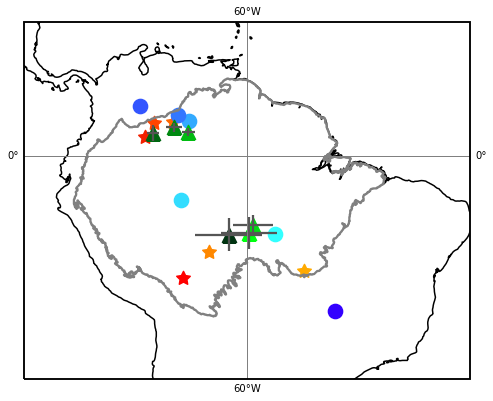

In [105]:
obj_pr(sam_ctl_loni_ss, sam_ctl_lati_ss, sam_def_loni_ss, sam_def_lati_ss, sam_imerg_loni_ss, sam_imerg_lati_ss, lon_std_ss, lat_std_ss, -30, 20, -90, -30)

In [170]:
obj_three_pr(sam_ctl_yr_loni[2], sam_ctl_yr_lati[2], sam_ctl_yr_loni[2], sam_ctl_yr_lati[2], sam_ctl_yr_loni[2], sam_ctl_yr_lati[2], -25, 15, -85, -35)

NameError: name 'sam_ctl_yr_loni' is not defined

In [47]:
obj_pr(sam_ctl_loni, sam_ctl_lati, sam_imerg_mean_loni, sam_imerg_mean_lati, -30, 20, -90, -30)

NameError: name 'sam_ctl_loni' is not defined

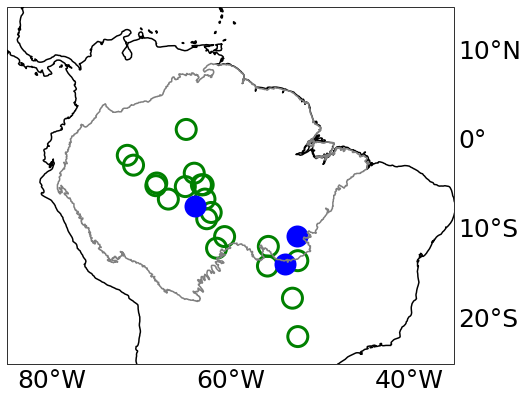

In [75]:
obj_pr_imerg_only(sam_imerg_nov_mean_loni, sam_imerg_nov_mean_lati, sam_ctl_nov_loni, sam_ctl_nov_lati, -30, 20, -90, -30)

In [128]:
print(sam_ctl_season_lati)
print(sam_def_season_lati)

print(sam_ctl_season_loni)
print(sam_def_season_loni)

[array([1.75]), array([-17.75]), array([4.85])]
[array([1.35]), array([-12.55]), array([4.15])]
[array([-70.15]), array([-66.75]), array([-68.85])]
[array([-72.15]), array([-63.25]), array([-70.85])]


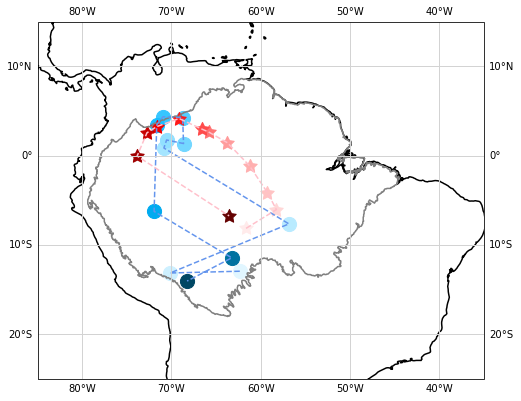

In [93]:
obj_pr(sam_def_loni, sam_def_lati, sam_imerg_mean_loni, sam_imerg_mean_lati, -30, 20, -90, -30)

In [54]:
sam_ctl_lati

[array([-8.75]),
 array([-4.95]),
 array([nan]),
 array([1.95]),
 array([2.45]),
 array([1.65]),
 array([3.85]),
 array([4.55]),
 array([5.55]),
 array([-5.65]),
 array([-13.45]),
 array([-17.45])]

## q80 precipitation with wind

In [7]:
# ctl
path_ctl =Path('/scratch/m/m300948/test_04/3d/wind')
file_ctl_u = sorted([str(f) for f in path_ctl.glob(f'ctl_daily_ua_plev_202*.nc')])[:]
file_ctl_v = sorted([str(f) for f in path_ctl.glob(f'ctl_daily_va_plev_202*.nc')])[:]

uas_ctl = xr.open_mfdataset(file_ctl_u,parallel=True)['ua'].isel(plev=4).chunk({'time':24})
vas_ctl = xr.open_mfdataset(file_ctl_v,parallel=True)['va'].isel(plev=4).chunk({'time':24})

In [8]:
# def
path_def =Path('/scratch/m/m300948/def_100/3d/wind')
file_def_u = sorted([str(f) for f in path_def.glob(f'def_daily_ua_plev_202*.nc')])[:]
file_def_v = sorted([str(f) for f in path_def.glob(f'def_daily_va_plev_202*.nc')])[:]

uas_def = xr.open_mfdataset(file_def_u,parallel=True)['ua'].isel(plev=4).chunk({'time':24})
vas_def = xr.open_mfdataset(file_def_v,parallel=True)['va'].isel(plev=4).chunk({'time':24})

In [9]:
# ctl - wind
uas_ctl_mon = uas_ctl.groupby('time.month').mean('time')
vas_ctl_mon = vas_ctl.groupby('time.month').mean('time')

In [10]:
# def - wind
uas_def_mon = uas_def.groupby('time.month').mean('time')
vas_def_mon = vas_def.groupby('time.month').mean('time')

In [11]:
# ctl
# wet
wet_uas_ctl = uas_ctl_mon.where(uas_ctl_mon.month.isin([1,2,12]), drop=True)
wet_vas_ctl = vas_ctl_mon.where(vas_ctl_mon.month.isin([1,2,12]), drop=True)

# dry
dry_uas_ctl = uas_ctl_mon.where(uas_ctl_mon.month.isin([7,8,9]), drop=True)
dry_vas_ctl = vas_ctl_mon.where(vas_ctl_mon.month.isin([7,8,9]), drop=True)

In [12]:
# def
# wet
wet_uas_def = uas_def_mon.where(uas_def_mon.month.isin([1,2,12]), drop=True)
wet_vas_def = vas_def_mon.where(vas_def_mon.month.isin([1,2,12]), drop=True)

# dry
dry_uas_def = uas_def_mon.where(uas_def_mon.month.isin([7,8,9]), drop=True)
dry_vas_def = vas_def_mon.where(vas_def_mon.month.isin([7,8,9]), drop=True)

In [13]:
# ctl
wet_uas_ctl_mean = wet_uas_ctl.mean("month")
wet_vas_ctl_mean = wet_vas_ctl.mean("month")

dry_uas_ctl_mean = dry_uas_ctl.mean("month")
dry_vas_ctl_mean = dry_vas_ctl.mean("month")

In [14]:
# def
wet_uas_def_mean = wet_uas_def.mean("month")
wet_vas_def_mean = wet_vas_def.mean("month")

dry_uas_def_mean = dry_uas_def.mean("month")
dry_vas_def_mean = dry_vas_def.mean("month")

In [15]:
# [-20,20],[-80,-40]]
wet_uas_ctl_mean_sel = wet_uas_ctl_mean.where(((wet_uas_ctl_mean.lat>=-20) & (wet_uas_ctl_mean.lat<=20)) & ((wet_uas_ctl_mean.lon>=-80) & (wet_uas_ctl_mean.lon<=-40)),drop=True)
wet_vas_ctl_mean_sel = wet_vas_ctl_mean.where(((wet_vas_ctl_mean.lat>=-20) & (wet_vas_ctl_mean.lat<=20)) & ((wet_vas_ctl_mean.lon>=-80) & (wet_vas_ctl_mean.lon<=-40)),drop=True)

dry_uas_ctl_mean_sel = dry_uas_ctl_mean.where(((dry_uas_ctl_mean.lat>=-20) & (dry_uas_ctl_mean.lat<=20)) & ((dry_uas_ctl_mean.lon>=-80) & (dry_uas_ctl_mean.lon<=-40)),drop=True)
dry_vas_ctl_mean_sel = dry_vas_ctl_mean.where(((dry_vas_ctl_mean.lat>=-20) & (dry_vas_ctl_mean.lat<=20)) & ((dry_vas_ctl_mean.lon>=-80) & (dry_vas_ctl_mean.lon<=-40)),drop=True)

In [16]:
wet_uas_def_mean_sel = wet_uas_def_mean.where(((wet_uas_def_mean.lat>=-20) & (wet_uas_def_mean.lat<=20)) & ((wet_uas_def_mean.lon>=-80) & (wet_uas_def_mean.lon<=-40)),drop=True)
wet_vas_def_mean_sel = wet_vas_def_mean.where(((wet_vas_def_mean.lat>=-20) & (wet_vas_def_mean.lat<=20)) & ((wet_vas_def_mean.lon>=-80) & (wet_vas_def_mean.lon<=-40)),drop=True)

dry_uas_def_mean_sel = dry_uas_def_mean.where(((dry_uas_def_mean.lat>=-20) & (dry_uas_def_mean.lat<=20)) & ((dry_uas_def_mean.lon>=-80) & (dry_uas_def_mean.lon<=-40)),drop=True)
dry_vas_def_mean_sel = dry_vas_def_mean.where(((dry_vas_def_mean.lat>=-20) & (dry_vas_def_mean.lat<=20)) & ((dry_vas_def_mean.lon>=-80) & (dry_vas_def_mean.lon<=-40)),drop=True)

In [17]:
wet_diff_uas_ctl_mean = wet_uas_def_mean_sel - wet_uas_ctl_mean_sel
wet_diff_vas_ctl_mean = wet_vas_def_mean_sel - wet_vas_ctl_mean_sel

dry_diff_uas_ctl_mean = dry_uas_def_mean_sel - dry_uas_ctl_mean_sel
dry_diff_vas_ctl_mean = dry_vas_def_mean_sel - dry_vas_ctl_mean_sel

_plotting windvector with dataset_

In [18]:
def plot_adv(title, dset_uas, dset_vas, q_interval, data, colormap, extend, varmin, varmax, space, 
                    lat_min, lat_max, int_lat, lon_min, lon_max, int_lon):
    dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
    AMZ_BD = dset_bd.AMAZON_BIOMES
    
    proj = ccrs.PlateCarree(central_longitude=180) # Create Mollweide projections
    fig  = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection=proj)
    
    minlon = lon_min + 5 + 180 #on
    maxlon = lon_max - 5 + 180 #on
    
    ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],proj) #on
    ax.coastlines(resolution='50m', linewidth=1.5, color='black')
    ax.gridlines(draw_labels=True, linewidth=1, color='grey',
                        xlocs=range(-180,180,30), ylocs=range(-90,90,30), crs=ccrs.PlateCarree())
    plot = data.plot(
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      cmap=colormap,
                      vmin=varmin,
                      vmax=varmax,
                     # cbar_kwargs={'label': 'Surface Temperature [K]',
                     #              'extend': 'both',
                     #              'shrink': .5,
                     #              'orientation': 'horizontal'},
                      add_colorbar=False
                     )
    bounds = np.linspace(varmin,varmax, space)
    cb = plt.colorbar(plot, orientation="horizontal", fraction=0.05, pad=0.10, extend=extend,ticks=bounds, boundaries=bounds)
    cb.ax.tick_params(labelsize=20)
    cb.ax.set_xticklabels(bounds,rotation=270)
    
    vplot=ax.quiver(dset_uas.lon.values[::q_interval], dset_uas.lat.values[::q_interval], 
                    #dset_uas.drop('land_sea_mask').mean('time').isel(plev=vlevel).values[::q_interval], 
                    #dset_vas.drop('land_sea_mask').mean('time').isel(plev=vlevel).values[::q_interval],
                    dset_uas.values[::q_interval, ::q_interval], 
                    dset_vas.values[::q_interval, ::q_interval],
                    scale_units='xy',
                    scale=0.5, #1.0 for original, 0.05 diff
                    width=0.005,
                    angles='xy',
                    transform=ccrs.PlateCarree())
    #vref = ax.quiverkey(vplot, 0.9, 0.905, 20,
    #                            r'$20 \frac{m}{s}$',
    #                            labelpos='E',
    #                        coordinates='figure', zorder=5)
    ax.quiverkey(vplot, X=0.85, Y=0.9, U=5,
             label=r'$5 \frac{m}{s}$', labelpos='E',coordinates='figure')
    ax.set_title(title, y=1.1, fontsize=25)
    fig.tight_layout()
    
    kw = {'levels':[-1], 'colors':['red'], 'linestyles':['solid']}
    plot_bd = AMZ_BD.plot.contour( 
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      **kw
                     )

In [23]:
def plot_quiver(title, dset_uas, dset_vas, q_interval, scale, 
                    lat_min, lat_max, int_lat, lon_min, lon_max, int_lon):
    dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
    AMZ_BD = dset_bd.AMAZON_BIOMES
    
    proj = ccrs.PlateCarree(central_longitude=180) # Create Mollweide projections
    fig  = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection=proj)
    
    minlon = lon_min + 5 + 180 #on
    maxlon = lon_max - 5 + 180 #on
    
    ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],proj) #on
    ax.coastlines(resolution='50m', linewidth=1.5, color='black')
    ax.gridlines(draw_labels=True, linewidth=1, color='grey',
                        xlocs=range(-180,180,30), ylocs=range(-90,90,30), crs=ccrs.PlateCarree())
    
    vplot=ax.quiver(dset_uas.lon.values[::q_interval], dset_uas.lat.values[::q_interval], 
                    #dset_uas.drop('land_sea_mask').mean('time').isel(plev=vlevel).values[::q_interval], 
                    #dset_vas.drop('land_sea_mask').mean('time').isel(plev=vlevel).values[::q_interval],
                    dset_uas.values[::q_interval, ::q_interval], 
                    dset_vas.values[::q_interval, ::q_interval],
                    scale_units='xy',
                    scale=scale, #1.0 for original, 0.05 diff
                    width=0.005,
                    angles='xy',
                    transform=ccrs.PlateCarree())
    #vref = ax.quiverkey(vplot, 0.9, 0.905, 20,
    #                            r'$20 \frac{m}{s}$',
    #                            labelpos='E',
    #                        coordinates='figure', zorder=5)
    ax.quiverkey(vplot, X=0.85, Y=0.9, U=5,
             label=r'$5 \frac{m}{s}$', labelpos='E',coordinates='figure')
    ax.set_title(title, y=1.1, fontsize=25)
    fig.tight_layout()
    
    kw = {'levels':[-1], 'colors':['red'], 'linestyles':['solid']}
    plot_bd = AMZ_BD.plot.contour( 
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      **kw
                     )

In [24]:
plot_quiver('Rainbelt-diff', dry_uas_def_mean_sel, dry_vas_def_mean_sel, 40, 1, -40, 20, 20, -100, -30, 20)

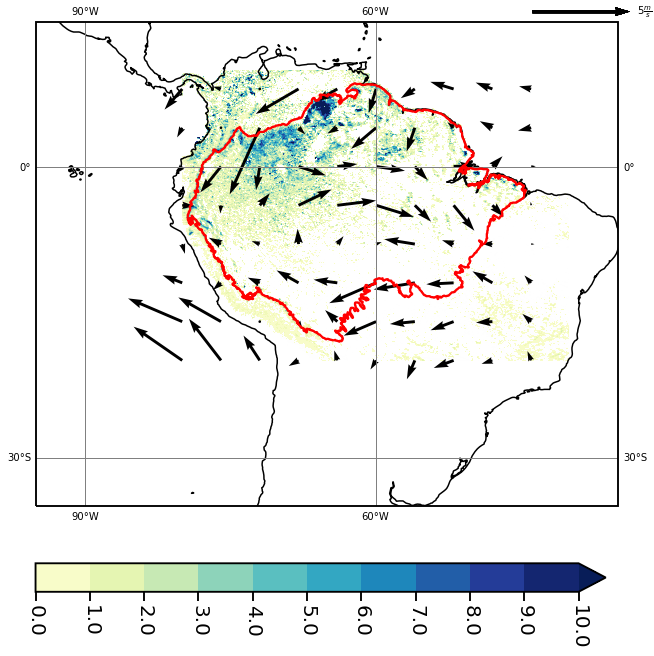

In [208]:
#title, dset_uas, dset_vas, q_interval, data, colormap, extend, varmin, varmax, space, 
#                    lat_min, lat_max, int_lat, lon_min, lon_max, int_lon
plot_adv('Rainbelt-diff', dry_diff_uas_ctl_mean, dry_diff_vas_ctl_mean, 40, dry_diff_q80_area, YlGnBu_new, 'max', 0, 10, 11, -40, 20, 20, -100, -30, 20) # YlGnBu_new, 'max', 0, 20, 11

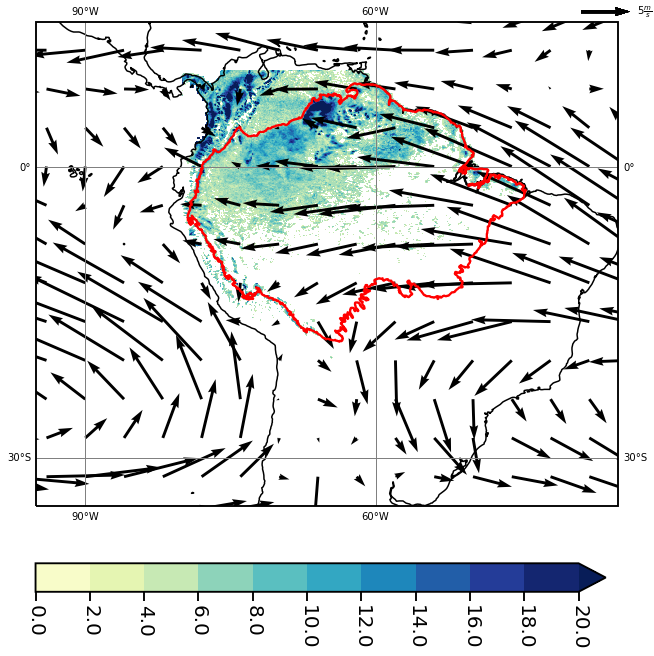

In [202]:
plot_adv('Rainbelt-dry (DEF)', dry_uas_def_mean, dry_vas_def_mean, 40, dry_def_q80_area, YlGnBu_new, 'max', 0, 20, 11, -40, 20, 20, -100, -30, 20)

/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


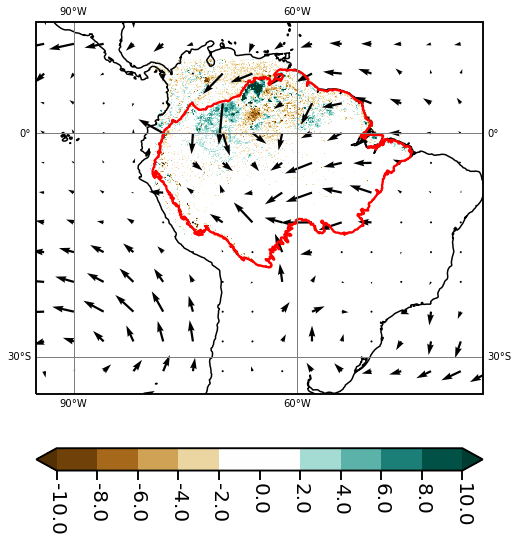

In [100]:
plot_adv('Rainbelt-dry (DIFF)', dry_uas_def_mean-dry_uas_ctl_mean, dry_vas_def_mean-dry_vas_ctl_mean, 40, dry_def_q80_area-dry_ctl_q80_area, BrBG_new, 
         'both', -10, 10, 11, -40, 20, 20, -100, -30, 20)

# Spatial correlation coefficient

In [210]:
print(np.shape(dry_diff_q80_area))
print(np.shape(dry_ctl_q80_area))

(300, 400)
(300, 400)


In [212]:
dry_diff_q80_area_1d = dry_diff_q80_area.values.reshape(-1)
dry_ctl_q80_area_1d = dry_ctl_q80_area.values.reshape(-1)
dry_diff_q80_area_1d = np.nan_to_num(dry_diff_q80_area_1d)
dry_ctl_q80_area_1d = np.nan_to_num(dry_ctl_q80_area_1d)

In [219]:
wet_diff_q80_area_1d = wet_diff_q80_area.values.reshape(-1)
wet_ctl_q80_area_1d = wet_ctl_q80_area.values.reshape(-1)
wet_diff_q80_area_1d = np.nan_to_num(wet_diff_q80_area_1d)
wet_ctl_q80_area_1d = np.nan_to_num(wet_ctl_q80_area_1d)

In [218]:
correlation_coefficient = np.corrcoef(dry_diff_q80_area_1d, dry_ctl_q80_area_1d)[0, 1]
print("Correlation coefficient:", correlation_coefficient)

Correlation coefficient: 0.4501709826169507


In [234]:
correlation_coefficient = np.corrcoef(wet_diff_q80_area_1d, wet_ctl_q80_area_1d)[0, 1]
print("Correlation coefficient:", correlation_coefficient)

Correlation coefficient: 0.14868999517434367


In [217]:
from scipy.spatial.distance import cosine, euclidean
# Calculate cosine similarity
cosine_similarity = 1 - cosine(dry_diff_q80_area_1d, dry_ctl_q80_area_1d)

# Calculate Euclidean distance
euclidean_distance = euclidean(dry_diff_q80_area_1d, dry_ctl_q80_area_1d)

# Print the similarity measures
print("Cosine similarity:", cosine_similarity)
print("Euclidean distance:", euclidean_distance)

Cosine similarity: 0.5677182674407959
Euclidean distance: 1567.4024658203125


In [220]:
from scipy.spatial.distance import cosine, euclidean
# Calculate cosine similarity
cosine_similarity = 1 - cosine(wet_diff_q80_area_1d, wet_ctl_q80_area_1d)

# Calculate Euclidean distance
euclidean_distance = euclidean(wet_diff_q80_area_1d, wet_ctl_q80_area_1d)

# Print the similarity measures
print("Cosine similarity:", cosine_similarity)
print("Euclidean distance:", euclidean_distance)

Cosine similarity: 0.4304037094116211
Euclidean distance: 2655.77685546875


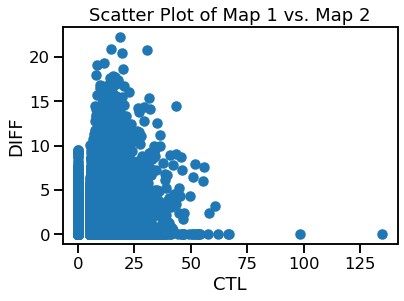

In [227]:
plt.scatter(dry_ctl_q80_area_1d, dry_diff_q80_area_1d)

# Add labels and title to the plot
plt.xlabel('CTL')
plt.ylabel('DIFF')
plt.title('Scatter Plot of Map 1 vs. Map 2')

# Show the plot
plt.show()``

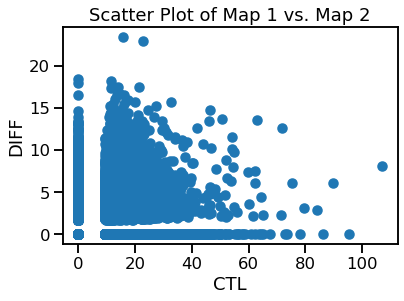

In [229]:
plt.scatter(wet_ctl_q80_area_1d, wet_diff_q80_area_1d)

# Add labels and title to the plot
plt.xlabel('CTL')
plt.ylabel('DIFF')
plt.title('Scatter Plot of Map 1 vs. Map 2')

# Show the plot
plt.show()

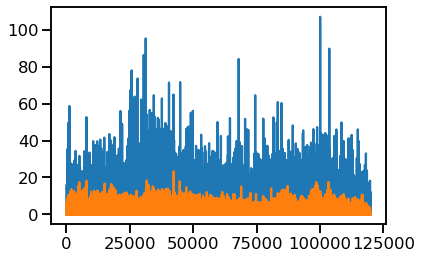

In [231]:
plt.plot(wet_ctl_q80_area_1d)
plt.plot(wet_diff_q80_area_1d)